In [1]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [2]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding_by_ncells_FIGURES'

In [4]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [5]:
pl.rcParams['pdf.fonttype']=42
pl.rcParams['ps.fonttype']=42

In [6]:
#mmc = multiple-comparisons correction (using bonferroni), where mcc = number of comparisons))

from matplotlib.lines import Line2D
def add_significance(ax, array1, array2, x1, x2, y, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),mcc=1,suppress_ns=True):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
    elif sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_ind(x,y)
    p = sig_func(array1, array2)[-1]
    sig_value = sig_func(array1, array2)[0]
    deltay = np.diff(ax.axis()[-2:])*ticksize
    if suppress_ns==True:
        if p <= thresholds[0]/mcc:
            line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
            ax.add_line(line)
            ax.text(np.mean([x1, x2]), y,
                    '*' if p > thresholds[1]/mcc else
                    '**' if p > thresholds[2]/mcc else
                    '***',
                    ha='center', fontsize=5)
    else:
        line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
        ax.add_line(line)
        ax.text(np.mean([x1, x2]), y+1,
            'n.s.' if p > thresholds[0]/mcc else
            '*' if p > thresholds[1]/mcc else
            '**' if p > thresholds[2]/mcc else
            '***',
            ha='center', fontsize=5)
    return sig_value, p

In [7]:
#mmc = multiple-comparisons correction (using bonferroni), where mcc = number of comparisons))

from matplotlib.lines import Line2D
def add_significance_point(ax, array1, array2, x1, y, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),
                                   mcc=1,color='k',symbol='*'):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
    elif sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
    p = sig_func(array1, array2)[-1]
    sig_value = sig_func(array1, array2)[0]
    deltay = np.diff(ax.axis()[-2:])*ticksize
    #line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
    #ax.add_line(line)
    ax.text(x1, y,
            "" if p > thresholds[0]/mcc else
            symbol if p > thresholds[1]/mcc else
            symbol+symbol if p > thresholds[2]/mcc else
            symbol+symbol+symbol,
            #symbol if p < thresholds[1]/mcc else
            #"",
            ha='center', fontsize=5,color=color)
    return sig_value, p

In [8]:
def report_stats (array1, array2, sig_func=None,mcc=1):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
        U = sig_func(array1, array2)[0]
        z = ((U-((loops*loops)/2))/(np.sqrt(((loops*loops)*(loops+loops+1))/12)))
        r = z/np.sqrt(loops*2)
        p = sig_func(array1, array2)[-1]
        print "U =",U,"p =",p*mcc,"r =",r
    if sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_ind(x, y)
        cohens_d = (np.mean(array1)-np.mean(array2))/np.sqrt((np.std(array1)**2+np.std(array2)**2)/2)
        p = sig_func(array1, array2)[-1]
        print sig_func(array1, array2),"d =", cohens_d, 'corrected p =',p*mcc
    if sig_func is 'fishers':
        table = array1,array2
        sig_func = lambda x: sstats.fisher_exact(x, alternative='two-sided')
        p = sig_func(table)[-1]
        odds_ratio = sig_func(table)[0]
        print sig_func(table),"odd's ratio =", odds_ratio, 'corrected p =',p*mcc
        

def report_stats_chance (array1, chance=0.5, sig_func=None,mcc=1):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        U = sig_func(subtracted)[0]
        z = ((U-((loops*loops)/2))/(np.sqrt(((loops*loops)*(loops+loops+1))/12)))
        r = z/np.sqrt(loops*2)
        print sig_func(subtracted),"r =",r
    elif sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        cohens_d = (np.mean(array1)-chance)/np.std(array1)
        print sig_func(array1,chance),"d =",cohens_d

In [9]:
def sig_vs_chance(ax, array1, chance, x1, y1, loops=10, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),colors='k'):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        p = sig_func(subtracted)[-1]
        sig_value = sig_func(subtracted)[0]
    elif sig_func is ttest:
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        p = sig_func(array1,chance)[-1]
        sig_value = sig_func(array1,chance)[0]
    ax.text(x1, y1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4, color=colors)
    return sig_value, p

In [11]:
delta_t05s = 0.5
t_start05s = -5.5 
t_stop05s = 10.5

delta_t1s = 1
t_start1s = -5 
t_stop1s  = 11 

delta_t15s = 1
t_start15s = -5.5 
t_stop15s = 10.5  

delta_t2s = 2
t_start2s = -4
t_stop2s  = 10

In [12]:
sessions = 'expo','pre','post','post_hiatus'
bins = ['05s','1s','15s','2s']
bin_ranges=[]
for tb in bins:
    if tb == '05s':
        div=0.5
    elif tb=='15s':
        div=1.0
    else:
        div=tb[:-1]
            #print range(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
    #for t in range(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div)))):
    bin_ranges.append(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
print bin_ranges

[32, 16, 16, 7]


In [13]:
#import results from notebooks
for tb,i,s in zip(bins[:2],range(len(bins[:2])),[10,5]):
    for t in range(s,bin_ranges[i]-s): # only take bins around CS and US, to speed up anlaysis
        for reg in 'dhpc','vhpc':
            exec("scores_%s_%s_%s = ut.load_variable('scores_%s_%s','../notebooks/autorestore/decoding_by_ncells_%s')"%(tb,t,reg,tb,t,reg))
            exec("ncells_%s_%s_%s = ut.load_variable('ncells_%s_%s','../notebooks/autorestore/decoding_by_ncells_%s')"%(tb,t,reg,tb,t,reg))
            exec("scores_%s_%s_ncells_%s = ut.load_variable('scores_%s_%s_ncells','../notebooks/autorestore/decoding_by_ncells_%s')"%(tb,t,reg,tb,t,reg))
            exec("scores_cspm_%s_%s_%s = ut.load_variable('scores_cspm_%s_%s','../notebooks/autorestore/decoding_by_ncells_%s')"%(tb,t,reg,tb,t,reg))
            exec("ncells_cspm_%s_%s_%s = ut.load_variable('ncells_cspm_%s_%s','../notebooks/autorestore/decoding_by_ncells_%s')"%(tb,t,reg,tb,t,reg))
            exec("scores_cspm_%s_%s_ncells_%s = ut.load_variable('scores_cspm_%s_%s_ncells','../notebooks/autorestore/decoding_by_ncells_%s')"%(tb,t,reg,tb,t,reg))
            exec("scores_valence_%s_%s_%s = ut.load_variable('scores_valence_%s_%s','../notebooks/autorestore/decoding_by_ncells_%s')"%(tb,t,reg,tb,t,reg))
            exec("ncells_valence_%s_%s_%s = ut.load_variable('ncells_valence_%s_%s','../notebooks/autorestore/decoding_by_ncells_%s')"%(tb,t,reg,tb,t,reg))
            exec("scores_valence_%s_%s_ncells_%s = ut.load_variable('scores_valence_%s_%s_ncells','../notebooks/autorestore/decoding_by_ncells_%s')"%(tb,t,reg,tb,t,reg))
            exec("cellreg_scores_%s_%s_%s = ut.load_variable('cellreg_scores_%s_%s','../notebooks/autorestore/decoding_by_ncells_%s')"%(tb,t,reg,tb,t,reg))
            exec("cellreg_ncells_%s_%s_%s = ut.load_variable('cellreg_ncells_%s_%s','../notebooks/autorestore/decoding_by_ncells_%s')"%(tb,t,reg,tb,t,reg))
            exec("cellreg_scores_%s_%s_ncells_%s = ut.load_variable('cellreg_scores_%s_%s_ncells','../notebooks/autorestore/decoding_by_ncells_%s')"%(tb,t,reg,tb,t,reg))
            exec("cellreg_scores_cspm_%s_%s_%s = ut.load_variable('cellreg_scores_cspm_%s_%s','../notebooks/autorestore/decoding_by_ncells_%s')"%(tb,t,reg,tb,t,reg))
            exec("cellreg_scores_cspm_%s_%s_ncells_%s = ut.load_variable('cellreg_scores_cspm_%s_%s_ncells','../notebooks/autorestore/decoding_by_ncells_%s')"%(tb,t,reg,tb,t,reg))

In [14]:
loops=10
for tb,i,s in zip(bins[:2],range(len(bins[:2])),[10,5]):
    for t in range(s,bin_ranges[i]-s): # only take bins around CS and US, to speed up anlaysis
        for comp_la in ['scores','scores_cspm','scores_valence','cellreg_scores','cellreg_scores_cspm']:
            for reg in 'dhpc','vhpc':
                exec("ttest_%s_%s_%s = {}"%(tb,t,comp_la))
                exec("mannwhitU_%s_%s_%s = {}"%(tb,t,comp_la))
                for sess in sessions:
                    try:
                        exec("ttest_%s_%s_%s['%s'] = sstats.ttest_ind(%s_%s_%s_dhpc['%s'][:loops],\
                           %s_%s_%s_vhpc['%s'][:loops])"%(tb,t,comp_la,sess,comp_la,tb,t,sess,comp_la,tb,t,sess))
                        exec("mannwhitU_%s_%s_%s['%s'] = sstats.mannwhitneyu(%s_%s_%s_dhpc['%s'][:loops],\
                           %s_%s_%s_vhpc['%s'][:loops])"%(tb,t,comp_la,sess,comp_la,tb,t,sess,comp_la,tb,t,sess))
                    except:
                        print "NOPE",comp_la,sess,"    ", # no data for cellreg expo, so expect that to not run

NOPE cellreg_scores expo      NOPE cellreg_scores expo      NOPE cellreg_scores_cspm expo      NOPE cellreg_scores_cspm expo      NOPE cellreg_scores expo      NOPE cellreg_scores expo      NOPE cellreg_scores_cspm expo      NOPE cellreg_scores_cspm expo      NOPE cellreg_scores expo      NOPE cellreg_scores expo      NOPE cellreg_scores_cspm expo      NOPE cellreg_scores_cspm expo      NOPE cellreg_scores expo      NOPE cellreg_scores expo      NOPE cellreg_scores_cspm expo      NOPE cellreg_scores_cspm expo      NOPE cellreg_scores expo      NOPE cellreg_scores expo      NOPE cellreg_scores_cspm expo      NOPE cellreg_scores_cspm expo      NOPE cellreg_scores expo      NOPE cellreg_scores expo      NOPE cellreg_scores_cspm expo      NOPE cellreg_scores_cspm expo      NOPE cellreg_scores expo      NOPE cellreg_scores expo      NOPE cellreg_scores_cspm expo      NOPE cellreg_scores_cspm expo      NOPE cellreg_scores expo      NOPE cellreg_scores expo      NOPE cellreg_scores_cspm expo 

In [15]:
dark_co = ('forestgreen','darkcyan','firebrick')

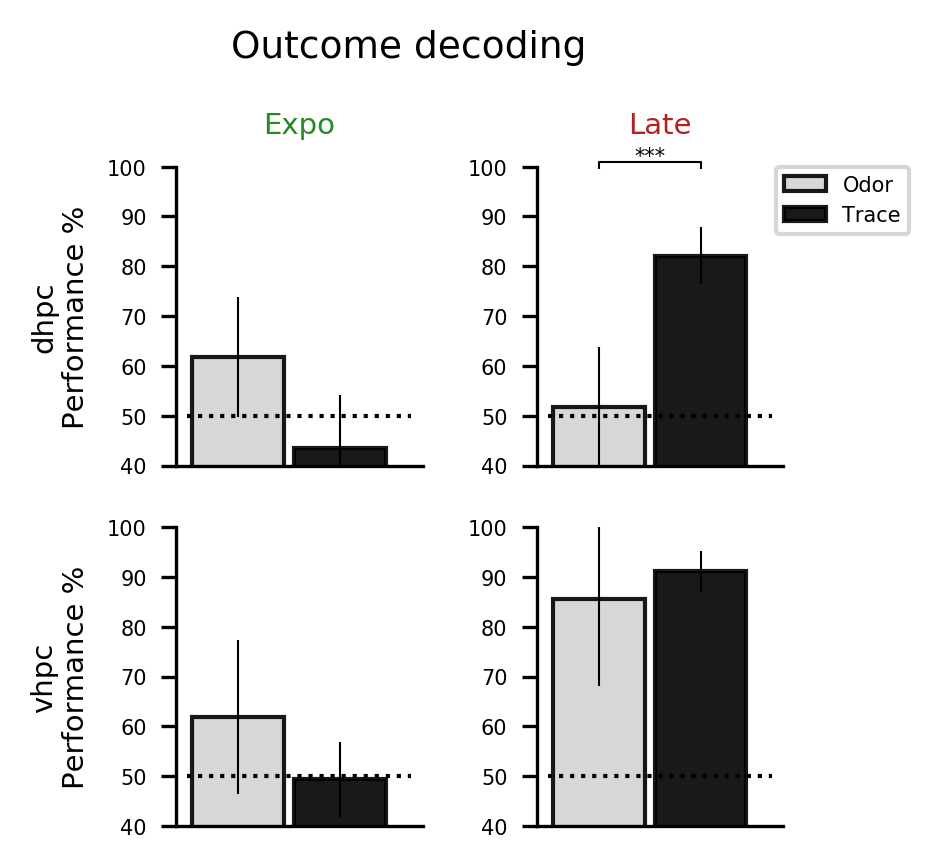

In [16]:
fig, ax = pl.subplots(2,2, figsize=(2.8, 2.7))
loops=10
tb='1s'
for reg,r in zip(['dhpc','vhpc'],range(2)):
    for i,k,c,la in zip(range(2),[5,8],['lightgrey','k'],['Odor','Trace']):
        for y,sess in zip(range(2),['expo','post']):
            ax[r][y].bar(i,np.mean(eval("scores_valence_%s_%s_%s[sess][:loops]"%(tb,k,reg)))*100,width=.9,
                      color=c,alpha=.9,label=la,edgecolor='k')
            exec("s_%s_%s_%s = np.array(np.std(scores_valence_%s_%s_%s[sess][:loops]*100))"%(k,reg,sess,tb,k,reg))
            ax[r][y].errorbar(i,np.mean(eval("scores_valence_%s_%s_%s[sess][:loops]"%(tb,k,reg)))*100,yerr=eval('s_%s_%s_%s'%(k,reg,sess)),color='k')
for reg,x in zip(['dhpc','vhpc'],range(2)):
    for y in range(2):
        ax[x][y].set_ylim(40, 100)
        #ax[x].set_xlim(-5, 9)
        ax[x][y].hlines(50, -0.5,1.7, color='k', lw=1, linestyles='dotted')
        #ax[x].set_xlabel('Comparison')
        ax[x][0].set_ylabel(reg+'\nPerformance %')
        ax[x][y].tick_params(axis='x',bottom='off',labelbottom='off')

pvs=[]
for reg,r in zip(['dhpc','vhpc'],range(2)):
    for y,sess,q in zip(range(2),sessions[1:],[101,101]):
        pvs.append(add_significance(ax[r][y], eval("scores_valence_%s_5_%s[sess][:loops]"%(tb,reg)),
                    eval("scores_valence_%s_8_%s[sess][:loops]"%(tb,reg)),0,1,q))
#for i,k,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),sessions[1:]):
#        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_%s_lmin_outcome_averaged[sess][:loops]"%(k))[:loops],.5,i,
#               np.mean(eval("scores_tb_%s_lmin_outcome_averaged[sess][:loops]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0][0].set_title('Expo', color = dark_co[0], y=1.03)
ax[0][1].set_title('Late', color = dark_co[2], y=1.03)
ax[0][1].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Outcome decoding", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

#fig.savefig('../figures/%s_CSvsTr_outcome_decoding_earlylate.pdf'%NOTEBOOK_NAME)

U = 51.0 p = 0.969838641405 r = 0.0169030850946
U = 43.0 p = 0.621863158727 r = -0.118321595662


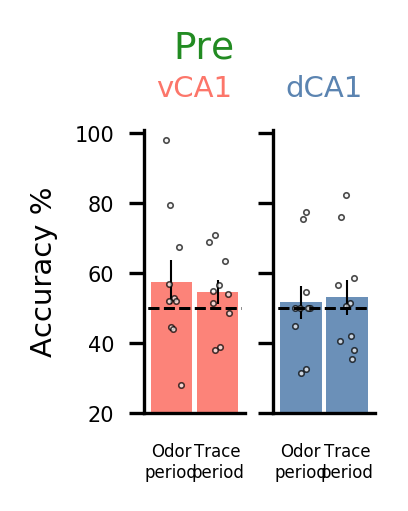

In [408]:
fig, ax = pl.subplots(1,2, figsize=(1.3, 1.5),sharey=True)
loops=10
tb='1s'
sess='expo'
width=.9
for reg,r,co in zip(['vhpc','dhpc'],range(2),['#FC766AFF','#5B84B1FF']):
    for i,k,c,la in zip(range(2),[5,8],['k','k'],['CS','Trace']):
            ax[r].bar(i,np.mean(eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k,reg)))*100,width=.9,
                      color=co,alpha=.9,label=la)
            exec("s_%s_%s_%s = np.array(np.std(scores_valence_%s_%s_%s[sess][-loops:])*100/np.sqrt(loops-1))"%(k,reg,sess,tb,k,reg))
            ax[r].errorbar(i,np.mean(eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k,reg)))*100,yerr=eval('s_%s_%s_%s'%(k,reg,sess)),color='k')
            ax[r].scatter(i+np.random.random(loops)*width/2-width/4.5,np.array(eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k,reg)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
            
for x in range (2):
    for y in range(2):
        ax[x].set_ylim(20, 101)
        #ax[x].set_xlim(-5, 9)
        ax[x].hlines(50, -0.5,1.5, color='k', lw=.7, linestyles='dashed')
        #ax[x].set_xlabel('Comparison')
        ax[0].set_ylabel('Accuracy %')
        ax[x].set_xticks([0,1])
        ax[x].set_xticklabels(['Odor\nperiod','Trace\nperiod'],fontsize=4)
        ax[x].tick_params(axis='x',bottom='off')

pvs=[]
k=[5,8]
for reg,r in zip(['vhpc','dhpc'],range(2)):
    for q in [101,101]:
        pvs.append(add_significance(ax[r], eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k[0],reg)),
                    eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k[1],reg)),0,1,q))
    report_stats(eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k[0],reg)),
                    eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k[1],reg)))
#for i,k,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),sessions[1:]):
#        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k))[-loops:],.5,i,
#               np.mean(eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('vCA1', y=1.03,color='#FC766AFF')
ax[1].set_title('dCA1', y=1.03,color='#5B84B1FF')
#ax[1].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Pre", fontsize=9, y=1.05, color=dark_co[0])

fig.tight_layout(pad=1)

fig.savefig('../figures/%s_CSvsTr_outcome_decoding_expo.pdf'%NOTEBOOK_NAME)

U = 73.5 p = 0.0818686237306 r = 0.397222499722
U = 36.0 p = 0.307307532725 r = -0.236643191324


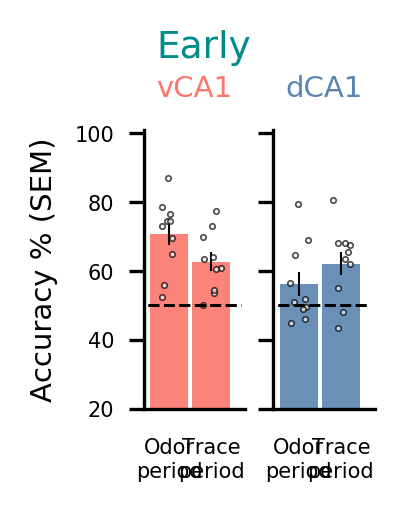

In [405]:
fig, ax = pl.subplots(1,2, figsize=(1.3, 1.5),sharey=True)
loops=10
tb='1s'
sess='pre'
width=.9
for reg,r,co in zip(['vhpc','dhpc'],range(2),['#FC766AFF','#5B84B1FF']):
    for i,k,c,la in zip(range(2),[5,8],['k','k'],['CS','Trace']):
            ax[r].bar(i,np.mean(eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k,reg)))*100,width=.9,
                      color=co,alpha=.9,label=la)
            exec("s_%s_%s_%s = np.array(np.std(scores_valence_%s_%s_%s[sess][-loops:])*100/np.sqrt(loops-1))"%(k,reg,sess,tb,k,reg))
            ax[r].errorbar(i,np.mean(eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k,reg)))*100,yerr=eval('s_%s_%s_%s'%(k,reg,sess)),color='k')
            ax[r].scatter(i+np.random.random(loops)*width/2-width/4.5,np.array(eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k,reg)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
            
for x in range (2):
    for y in range(2):
        ax[x].set_ylim(20, 101)
        #ax[x].set_xlim(-5, 9)
        ax[x].hlines(50, -0.5,1.7, color='k', lw=.7, linestyles='dashed')
        #ax[x].set_xlabel('Comparison')
        ax[0].set_ylabel('Accuracy % (SEM)')
        ax[x].set_xticks([0,1])
        ax[x].set_xticklabels(['Odor\nperiod','Trace\nperiod'])
        ax[x].tick_params(axis='x',bottom='off')

pvs=[]
k=[5,8]
for reg,r in zip(['vhpc','dhpc'],range(2)):
    for q in [101,101]:
        pvs.append(add_significance(ax[r], eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k[0],reg)),
                    eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k[1],reg)),0,1,q))
    report_stats(eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k[0],reg)),
                    eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k[1],reg)))
#for i,k,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),sessions[1:]):
#        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k))[-loops:],.5,i,
#               np.mean(eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('vCA1', y=1.03,color='#FC766AFF')
ax[1].set_title('dCA1', y=1.03,color='#5B84B1FF')
#ax[1].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Early", fontsize=9, y=1.05,color=dark_co[1])

fig.tight_layout(pad=1)

fig.savefig('../figures/%s_CSvsTr_outcome_decoding_pre.pdf'%NOTEBOOK_NAME)

U = 55.0 p = 0.733150311208 r = 0.0845154254729
U = 0.0 p = 0.000180634720808 r = -0.845154254729


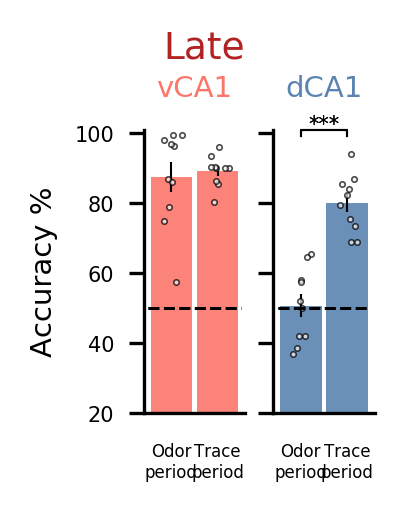

In [394]:
fig, ax = pl.subplots(1,2, figsize=(1.3, 1.5),sharey=True)
loops=10
tb='1s'
sess='post'
width=.9
for reg,r,co in zip(['vhpc','dhpc'],range(2),['#FC766AFF','#5B84B1FF']):
    for i,k,c,la in zip(range(2),[5,8],['k','k'],['CS','Trace']):
            ax[r].bar(i,np.mean(eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k,reg)))*100,width=.9,
                      color=co,alpha=.9,label=la)
            exec("s_%s_%s_%s = np.array(np.std(scores_valence_%s_%s_%s[sess][-loops:])*100/np.sqrt(loops-1))"%(k,reg,sess,tb,k,reg))
            ax[r].errorbar(i,np.mean(eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k,reg)))*100,yerr=eval('s_%s_%s_%s'%(k,reg,sess)),color='k')
            ax[r].scatter(i+np.random.random(loops)*width/2-width/4.5,np.array(eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k,reg)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
            
for x in range (2):
    for y in range(2):
        ax[x].set_ylim(20, 101)
        #ax[x].set_xlim(-5, 9)
        ax[x].hlines(50, -0.5,1.5, color='k', lw=.7, linestyles='dashed')
        #ax[x].set_xlabel('Comparison')
        ax[0].set_ylabel('Accuracy %')
        ax[x].set_xticks([0,1])
        ax[x].set_xticklabels(['Odor\nperiod','Trace\nperiod'],fontsize=4)
        ax[x].tick_params(axis='x',bottom='off')

pvs=[]
k=[5,8]
for reg,r in zip(['vhpc','dhpc'],range(2)):
    for q in [101,101]:
        pvs.append(add_significance(ax[r], eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k[0],reg)),
                    eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k[1],reg)),0,1,q))
    report_stats(eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k[0],reg)),
                    eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k[1],reg)))
#for i,k,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),sessions[1:]):
#        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k))[-loops:],.5,i,
#               np.mean(eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('vCA1', y=1.03,color='#FC766AFF')
ax[1].set_title('dCA1', y=1.03,color='#5B84B1FF')
#ax[1].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Late", fontsize=9, y=1.05, color=dark_co[2])

fig.tight_layout(pad=1)

fig.savefig('../figures/%s_CSvsTr_outcome_decoding_post.pdf'%NOTEBOOK_NAME)

U = 38.0 p = 0.384315351518 r = -0.202837021135
U = 0.0 p = 0.000180634720808 r = -0.845154254729


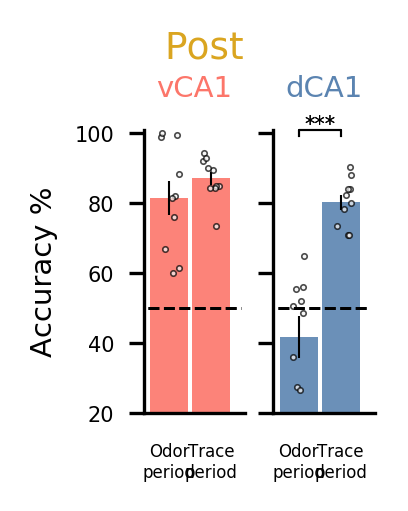

In [411]:
fig, ax = pl.subplots(1,2, figsize=(1.3, 1.5),sharey=True)
loops=10
tb='1s'
sess='post_hiatus'
width=.9
for reg,r,co in zip(['vhpc','dhpc'],range(2),['#FC766AFF','#5B84B1FF']):
    for i,k,c,la in zip(range(2),[5,8],['k','k'],['CS','Trace']):
            ax[r].bar(i,np.mean(eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k,reg)))*100,width=.9,
                      color=co,alpha=.9,label=la)
            exec("s_%s_%s_%s = np.array(np.std(scores_valence_%s_%s_%s[sess][-loops:])*100/np.sqrt(loops-1))"%(k,reg,sess,tb,k,reg))
            ax[r].errorbar(i,np.mean(eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k,reg)))*100,yerr=eval('s_%s_%s_%s'%(k,reg,sess)),color='k')
            ax[r].scatter(i+np.random.random(loops)*width/2-width/4.5,np.array(eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k,reg)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
            
for x in range (2):
    for y in range(2):
        ax[x].set_ylim(20, 101)
        #ax[x].set_xlim(-5, 9)
        ax[x].hlines(50, -0.5,1.7, color='k', lw=.7, linestyles='dashed')
        #ax[x].set_xlabel('Comparison')
        ax[0].set_ylabel('Accuracy %')
        ax[x].set_xticks([0,1])
        ax[x].set_xticklabels(['Odor\nperiod','Trace\nperiod'],fontsize=4)
        ax[x].tick_params(axis='x',bottom='off')

pvs=[]
k=[5,8]
for reg,r in zip(['vhpc','dhpc'],range(2)):
    for q in [101,101]:
        pvs.append(add_significance(ax[r], eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k[0],reg)),
                    eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k[1],reg)),0,1,q))
    report_stats(eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k[0],reg)),
                    eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k[1],reg)))
#for i,k,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),sessions[1:]):
#        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k))[-loops:],.5,i,
#               np.mean(eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('vCA1', y=1.03,color='#FC766AFF')
ax[1].set_title('dCA1', y=1.03,color='#5B84B1FF')
#ax[1].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Post", fontsize=9, y=1.05, color='goldenrod')

fig.tight_layout(pad=1)

fig.savefig('../figures/%s_CSvsTr_outcome_decoding_hiatus.pdf'%NOTEBOOK_NAME)

U = 11.5 p = 0.00403036661885 r = -0.650768776141
U = 48.0 p = 0.909003737344 r = -0.0338061701891


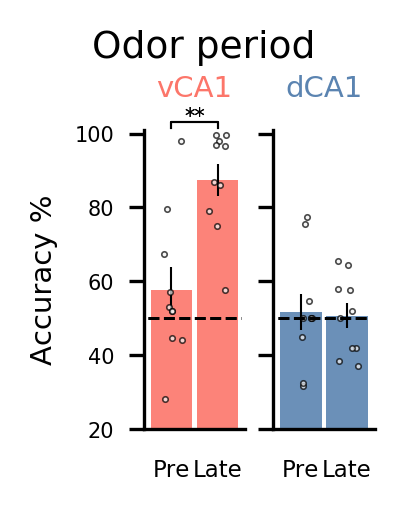

In [420]:
fig, ax = pl.subplots(1,2, figsize=(1.3, 1.5),sharey=True)
loops=10
tb='1s'
k=5
width=.9
for reg,r,co in zip(['vhpc','dhpc'],range(2),['#FC766AFF','#5B84B1FF']):
    for i,sess,c,la in zip(range(2),['expo','post'],['k','k'],['Pre','Late']):
            ax[r].bar(i,np.mean(eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k,reg)))*100,width=.9,
                      color=co,alpha=.9,label=la)
            exec("s_%s_%s_%s = np.array(np.std(scores_valence_%s_%s_%s[sess][-loops:])*100/np.sqrt(loops-1))"%(k,reg,sess,tb,k,reg))
            ax[r].errorbar(i,np.mean(eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k,reg)))*100,yerr=eval('s_%s_%s_%s'%(k,reg,sess)),color='k')
            ax[r].scatter(i+np.random.random(loops)*width/2-width/4.5,np.array(eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k,reg)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
            
for x in range (2):
    for y in range(2):
        ax[x].set_ylim(20, 101)
        #ax[x].set_xlim(-5, 9)
        ax[x].hlines(50, -0.5,1.5, color='k', lw=.7, linestyles='dashed')
        #ax[x].set_xlabel('Comparison')
        ax[0].set_ylabel('Accuracy %')
        ax[x].set_xticks([0,1])
        ax[x].set_xticklabels(['Pre','Late'],fontsize=5.5)
        ax[x].tick_params(axis='x',bottom='off')

pvs=[]
for reg,r in zip(['vhpc','dhpc'],range(2)):
    for q in [103,103]:
        pvs.append(add_significance(ax[r], eval("scores_valence_%s_%s_%s['expo'][-loops:]"%(tb,k,reg)),
                    eval("scores_valence_%s_%s_%s['post'][-loops:]"%(tb,k,reg)),0,1,q))
    report_stats(eval("scores_valence_%s_%s_%s['expo'][-loops:]"%(tb,k,reg)),
                    eval("scores_valence_%s_%s_%s['post'][-loops:]"%(tb,k,reg)))
#for i,k,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),sessions[1:]):
#        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k))[-loops:],.5,i,
#               np.mean(eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('vCA1', y=1.03,color='#FC766AFF')
ax[1].set_title('dCA1', y=1.03,color='#5B84B1FF')
#ax[1].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Odor period", fontsize=9, y=1.05, color='k')

fig.tight_layout(pad=1)

fig.savefig('../figures/%s_CS_outcome_decoding_PrPo.pdf'%NOTEBOOK_NAME)

U = 0.0 p = 0.000177610660689 r = -0.845154254729
U = 9.5 p = 0.00247819005567 r = -0.68457494633


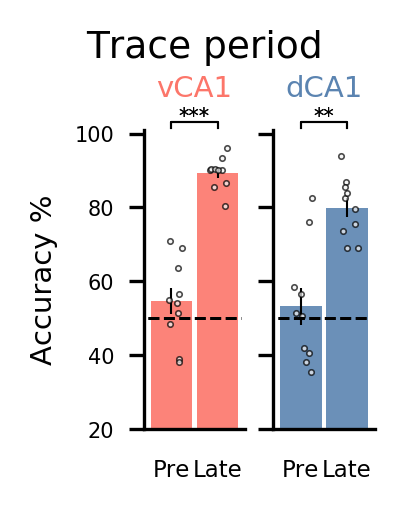

In [421]:
fig, ax = pl.subplots(1,2, figsize=(1.3, 1.5),sharey=True)
loops=10
tb='1s'
k=8
width=.9
for reg,r,co in zip(['vhpc','dhpc'],range(2),['#FC766AFF','#5B84B1FF']):
    for i,sess,c,la in zip(range(2),['expo','post'],['k','k'],['Pre','Late']):
            ax[r].bar(i,np.mean(eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k,reg)))*100,width=.9,
                      color=co,alpha=.9,label=la)
            exec("s_%s_%s_%s = np.array(np.std(scores_valence_%s_%s_%s[sess][-loops:])*100/np.sqrt(loops-1))"%(k,reg,sess,tb,k,reg))
            ax[r].errorbar(i,np.mean(eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k,reg)))*100,yerr=eval('s_%s_%s_%s'%(k,reg,sess)),color='k')
            ax[r].scatter(i+np.random.random(loops)*width/2-width/4.5,np.array(eval("scores_valence_%s_%s_%s[sess][-loops:]"%(tb,k,reg)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
            
for x in range (2):
    for y in range(2):
        ax[x].set_ylim(20, 101)
        #ax[x].set_xlim(-5, 9)
        ax[x].hlines(50, -0.5,1.5, color='k', lw=.7, linestyles='dashed')
        #ax[x].set_xlabel('Comparison')
        ax[0].set_ylabel('Accuracy %')
        ax[x].set_xticks([0,1])
        ax[x].set_xticklabels(['Pre','Late'],fontsize=5.5)
        ax[x].tick_params(axis='x',bottom='off')

pvs=[]
for reg,r in zip(['vhpc','dhpc'],range(2)):
    for q in [103,103]:
        pvs.append(add_significance(ax[r], eval("scores_valence_%s_%s_%s['expo'][-loops:]"%(tb,k,reg)),
                    eval("scores_valence_%s_%s_%s['post'][-loops:]"%(tb,k,reg)),0,1,q))
    report_stats(eval("scores_valence_%s_%s_%s['expo'][-loops:]"%(tb,k,reg)),
                    eval("scores_valence_%s_%s_%s['post'][-loops:]"%(tb,k,reg)))
#for i,k,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),sessions[1:]):
#        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k))[-loops:],.5,i,
#               np.mean(eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('vCA1', y=1.03,color='#FC766AFF')
ax[1].set_title('dCA1', y=1.03,color='#5B84B1FF')
#ax[1].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Trace period", fontsize=9, y=1.05, color='k')

fig.tight_layout(pad=1)

fig.savefig('../figures/%s_Tr_outcome_decoding_PrPo.pdf'%NOTEBOOK_NAME)

U = 30.5 p = 0.150158348508 r = -0.329610159344
U = 34.5 p = 0.251604322867 r = -0.261997818966


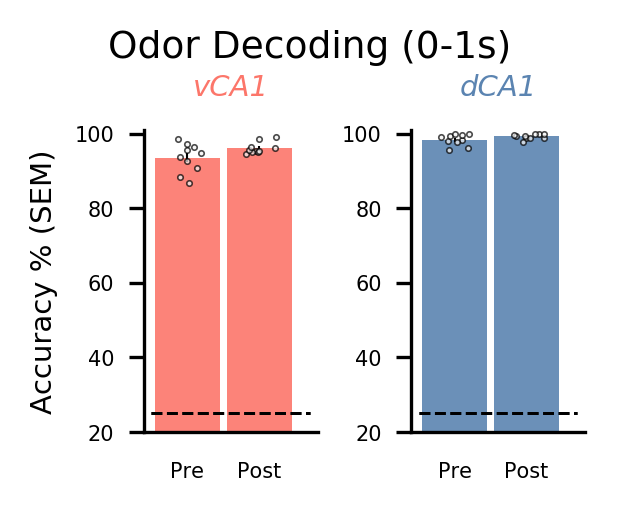

In [273]:
fig, ax = pl.subplots(1,2, figsize=(2, 1.5))
loops=10
tb='1s'
t=5 #time bin to plot (5 = 0-1s post odor delivery)
sess='post'
width=.9
for reg,r,co in zip(['vhpc','dhpc'],range(2),['#FC766AFF','#5B84B1FF']):
    for i,sess,la in zip(range(2),['expo','post'],['Pre','Post']):
        #for i,t,c,la in zip(range(2),[5,8],['k','k'],['CS','Trace']):
            ax[r].bar(i,np.mean(eval("scores_%s_%s_%s[sess][-loops:]"%(tb,t,reg)))*100,width=.9,
                      color=co,alpha=.9,label=la)
            exec("s_%s_%s_%s = np.array(np.std(scores_%s_%s_%s[sess][-loops:])*100/np.sqrt(loops-1))"%(t,reg,sess,tb,t,reg))
            ax[r].errorbar(i,np.mean(eval("scores_%s_%s_%s[sess][-loops:]"%(tb,t,reg)))*100,yerr=eval('s_%s_%s_%s'%(t,reg,sess)),color='k')
            ax[r].scatter(i+np.random.random(loops)*width/2-width/4.5,np.array(eval("scores_%s_%s_%s[sess][-loops:]"%(tb,t,reg)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
            
for x in range (2):
    for y in range(2):
        ax[x].set_ylim(20, 101)
        #ax[x].set_xlim(-5, 9)
        ax[x].hlines(25, -0.5,1.7, color='k', lw=.7, linestyles='dashed')
        #ax[x].set_xlabel('Comparison')
        ax[0].set_ylabel('Accuracy % (SEM)')
        ax[x].set_xticks([0,1])
        ax[x].set_xticklabels(['Pre','Post'])
        ax[x].tick_params(axis='x',bottom='off')

pvs=[]
sess=['expo','post']
for reg,r in zip(['vhpc','dhpc'],range(2)):
    for q in [101,101]:
        pvs.append(add_significance(ax[r], eval("scores_%s_%s_%s[sess[0]][-loops:]"%(tb,t,reg)),
                    eval("scores_%s_%s_%s[sess[1]][-loops:]"%(tb,t,reg)),0,1,q))
    report_stats(eval("scores_%s_%s_%s[sess[0]][-loops:]"%(tb,t,reg)),
                    eval("scores_%s_%s_%s[sess[1]][-loops:]"%(tb,t,reg)))
#for i,t,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),sessions[1:]):
#        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k))[-loops:],.5,i,
#               np.mean(eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('vCA1', y=1.03,color='#FC766AFF',fontstyle='italic')
ax[1].set_title('dCA1', y=1.03,color='#5B84B1FF',fontstyle='italic')
#ax[1].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Odor Decoding (0-1s)", fontsize=9, y=1.05)

fig.tight_layout(pad=1)

#fig.savefig('../figures/%s_Odor_decoding_prepost.pdf'%NOTEBOOK_NAME)

U = 58.5 p = 0.544136195254 r = 0.143676223304
U = 86.0 p = 0.00721877789446 r = 0.608511063405


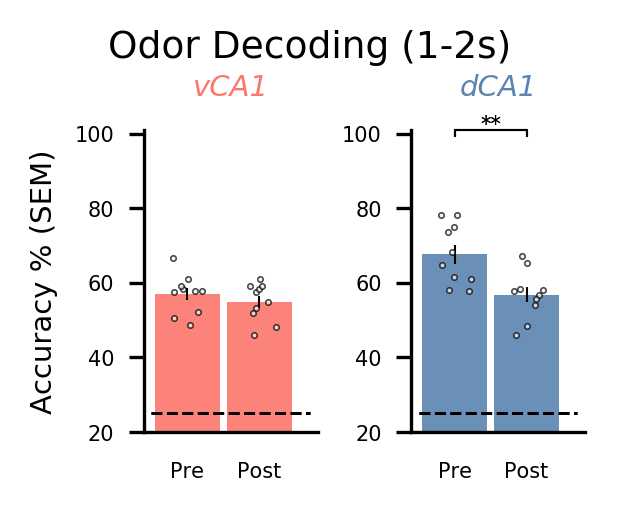

In [274]:
fig, ax = pl.subplots(1,2, figsize=(2, 1.5))
loops=10
tb='1s'
t=6 #time bin to plot (5 = 0-1s post odor delivery)
sess='post'
width=.9
for reg,r,co in zip(['vhpc','dhpc'],range(2),['#FC766AFF','#5B84B1FF']):
    for i,sess,la in zip(range(2),['expo','post'],['Pre','Post']):
        #for i,t,c,la in zip(range(2),[5,8],['k','k'],['CS','Trace']):
            ax[r].bar(i,np.mean(eval("scores_%s_%s_%s[sess][-loops:]"%(tb,t,reg)))*100,width=.9,
                      color=co,alpha=.9,label=la)
            exec("s_%s_%s_%s = np.array(np.std(scores_%s_%s_%s[sess][-loops:])*100/np.sqrt(loops-1))"%(t,reg,sess,tb,t,reg))
            ax[r].errorbar(i,np.mean(eval("scores_%s_%s_%s[sess][-loops:]"%(tb,t,reg)))*100,yerr=eval('s_%s_%s_%s'%(t,reg,sess)),color='k')
            ax[r].scatter(i+np.random.random(loops)*width/2-width/4.5,np.array(eval("scores_%s_%s_%s[sess][-loops:]"%(tb,t,reg)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
            
for x in range (2):
    for y in range(2):
        ax[x].set_ylim(20, 101)
        #ax[x].set_xlim(-5, 9)
        ax[x].hlines(25, -0.5,1.7, color='k', lw=.7, linestyles='dashed')
        #ax[x].set_xlabel('Comparison')
        ax[0].set_ylabel('Accuracy % (SEM)')
        ax[x].set_xticks([0,1])
        ax[x].set_xticklabels(['Pre','Post'])
        ax[x].tick_params(axis='x',bottom='off')

pvs=[]
sess=['expo','post']
for reg,r in zip(['vhpc','dhpc'],range(2)):
    for q in [101,101]:
        pvs.append(add_significance(ax[r], eval("scores_%s_%s_%s[sess[0]][-loops:]"%(tb,t,reg)),
                    eval("scores_%s_%s_%s[sess[1]][-loops:]"%(tb,t,reg)),0,1,q))
    report_stats(eval("scores_%s_%s_%s[sess[0]][-loops:]"%(tb,t,reg)),
                    eval("scores_%s_%s_%s[sess[1]][-loops:]"%(tb,t,reg)))
#for i,t,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),sessions[1:]):
#        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k))[-loops:],.5,i,
#               np.mean(eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('vCA1', y=1.03,color='#FC766AFF',fontstyle='italic')
ax[1].set_title('dCA1', y=1.03,color='#5B84B1FF',fontstyle='italic')
#ax[1].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Odor Decoding (1-2s)", fontsize=9, y=1.05)

fig.tight_layout(pad=1)

#fig.savefig('../figures/%s_Odor_decoding_prepost.pdf'%NOTEBOOK_NAME)

In [150]:
def plot_scores_vs_ncells(ncells, scores, labels=True, dot_color=(1, 0.7, 0.7), color='r', chance=None, ax=None,label=None):
    if ax is None:
        fig, ax = pl.subplots(1, 1, figsize=(1, 1))
    ax.plot(ncells, scores*100, 'o', ms=2, mew=0, color=dot_color, zorder=0,label=label)
    ax.errorbar(ncells[::loops], scores.reshape(-1, loops).mean(1)*100,
                np.std(scores.reshape(-1, loops), 1)*100/np.sqrt(loops-1),
                color=color)
    ax.set_ylim(0, 100)
    
    if labels:
        ax.set_xlabel("No. of Cells")
        ax.set_ylabel("Performance")

    if chance is not None:
        xmin, xmax, _, _  = ax.axis()
        ax.hlines(chance, xmin, xmax, linestyles='dashed', lw=0.5, color='k')

    return ax

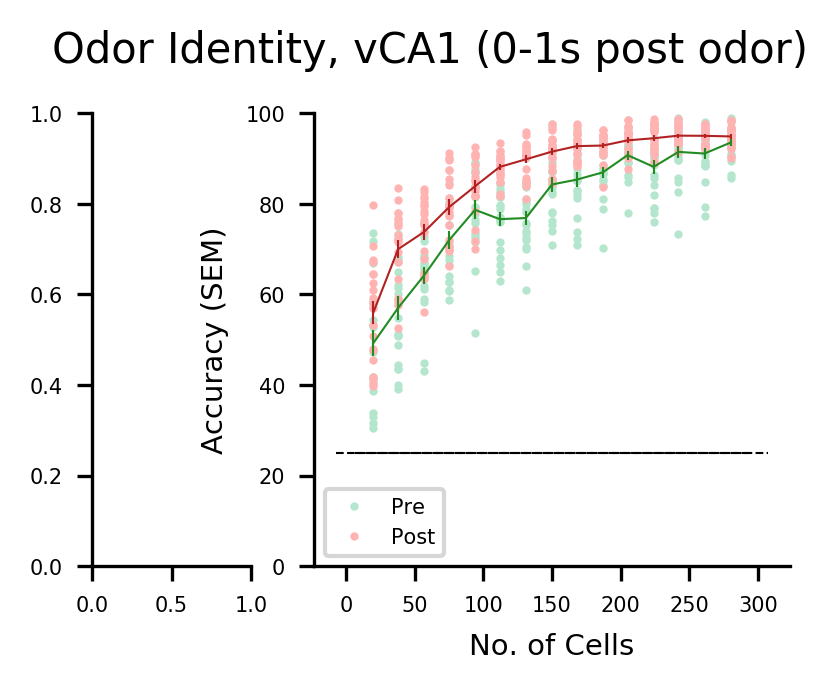

In [183]:
fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})
loops=20
sess1='expo'
sess2='post'
tb=5
plot_scores_vs_ncells(eval("ncells_1s_%s_vhpc[sess1]"%tb), eval("scores_1s_%s_ncells_vhpc"%tb)[sess1], dot_color=(0.7, 0.9, .8),label='Pre', color=dark_co[0], chance=25, ax=axs[1], labels=False)
plot_scores_vs_ncells(eval("ncells_1s_%s_vhpc[sess2]"%tb), eval("scores_1s_%s_ncells_vhpc"%tb)[sess2], ax=axs[1], color=dark_co[2],chance=25, labels=False,label='Post')
axs[1].legend()
axs[1].set_xlabel("No. of Cells")
axs[1].set_ylabel("Accuracy (SEM)")
fig.suptitle("Odor Identity, vCA1 (0-1s post odor)", fontsize=10,y=1.02)

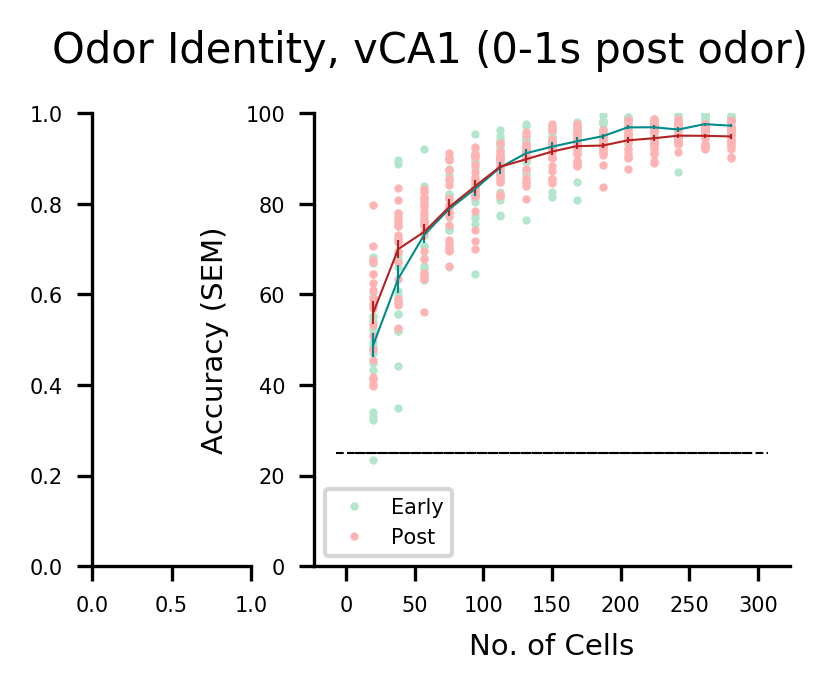

In [227]:
fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})
loops=20
sess1='pre'
sess2='post'
tb=5
plot_scores_vs_ncells(eval("ncells_1s_%s_vhpc[sess1]"%tb), eval("scores_1s_%s_ncells_vhpc"%tb)[sess1], dot_color=(0.7, 0.9, .8),label='Early', color=dark_co[1], chance=25, ax=axs[1], labels=False)
plot_scores_vs_ncells(eval("ncells_1s_%s_vhpc[sess2]"%tb), eval("scores_1s_%s_ncells_vhpc"%tb)[sess2], ax=axs[1], color=dark_co[2],chance=25, labels=False,label='Post')
axs[1].legend()
axs[1].set_xlabel("No. of Cells")
axs[1].set_ylabel("Accuracy (SEM)")
fig.suptitle("Odor Identity, vCA1 (0-1s post odor)", fontsize=10,y=1.02)

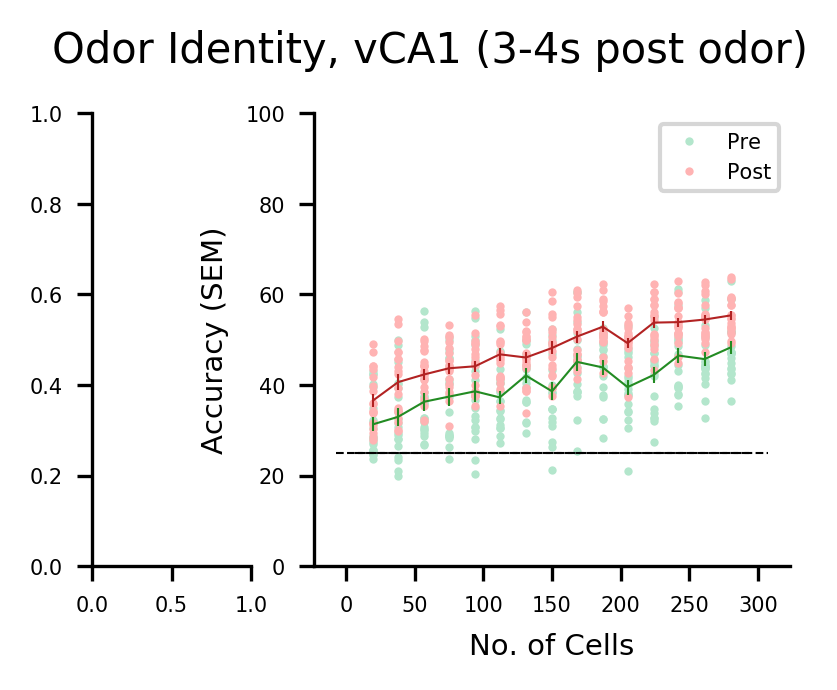

In [217]:
fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})
loops=20
sess1='expo'
sess2='post'
tb=8
plot_scores_vs_ncells(eval("ncells_1s_%s_vhpc[sess1]"%tb), eval("scores_1s_%s_ncells_vhpc"%tb)[sess1], dot_color=(0.7, 0.9, .8),label='Pre', color=dark_co[0], chance=25, ax=axs[1], labels=False)
plot_scores_vs_ncells(eval("ncells_1s_%s_vhpc[sess2]"%tb), eval("scores_1s_%s_ncells_vhpc"%tb)[sess2], ax=axs[1], color=dark_co[2],chance=25, labels=False,label='Post')
axs[1].legend()
axs[1].set_xlabel("No. of Cells")
axs[1].set_ylabel("Accuracy (SEM)")
fig.suptitle("Odor Identity, vCA1 (3-4s post odor)", fontsize=10,y=1.02)

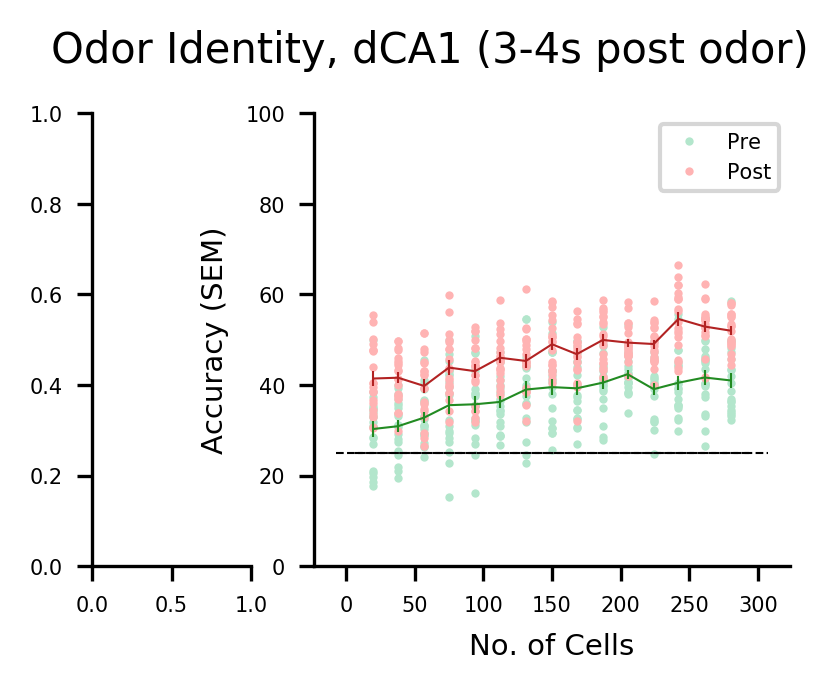

In [218]:
fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})
loops=20
sess1='expo'
sess2='post'
tb=8
plot_scores_vs_ncells(eval("ncells_1s_%s_dhpc[sess1]"%tb), eval("scores_1s_%s_ncells_dhpc"%tb)[sess1], dot_color=(0.7, 0.9, .8),label='Pre', color=dark_co[0], chance=25, ax=axs[1], labels=False)
plot_scores_vs_ncells(eval("ncells_1s_%s_dhpc[sess2]"%tb), eval("scores_1s_%s_ncells_dhpc"%tb)[sess2], ax=axs[1], color=dark_co[2],chance=25, labels=False,label='Post')
axs[1].legend()
axs[1].set_xlabel("No. of Cells")
axs[1].set_ylabel("Accuracy (SEM)")
fig.suptitle("Odor Identity, dCA1 (3-4s post odor)", fontsize=10,y=1.02)

In [139]:
#import these into JMP and run repeated measures anova over cell #
print scores_1s_5_ncells_vhpc['post']
print ncells_1s_5_vhpc['post']

[ 0.4025  0.455   0.4175  0.48    0.6725  0.7975  0.4125  0.5925  0.5075
  0.3975  0.645   0.5325  0.625   0.7075  0.4775  0.61    0.58    0.645
  0.675   0.57    0.59    0.5775  0.7575  0.6725  0.8075  0.73    0.78
  0.715   0.6925  0.635   0.525   0.835   0.75    0.59    0.78    0.7675
  0.765   0.5825  0.72    0.7225  0.56    0.765   0.7375  0.8125  0.6475
  0.825   0.795   0.6775  0.815   0.695   0.7575  0.805   0.7775  0.64
  0.635   0.8325  0.6475  0.7975  0.7525  0.785   0.79    0.6625  0.6975
  0.8125  0.7725  0.8425  0.8975  0.875   0.855   0.875   0.72    0.9
  0.7025  0.795   0.7075  0.7975  0.695   0.7825  0.9125  0.7525  0.9025
  0.8375  0.7425  0.86    0.885   0.925   0.7     0.87    0.8175  0.7175
  0.8175  0.8525  0.91    0.785   0.82    0.85    0.8275  0.91    0.835
  0.9075  0.86    0.9075  0.8225  0.88    0.875   0.8825  0.9175  0.8675
  0.8975  0.8875  0.9175  0.8475  0.865   0.9     0.8175  0.905   0.9
  0.895   0.935   0.8475  0.8775  0.9575  0.915   0.8575  0.905

U = 4.0 p = 0.000582839943179 r = -0.77754191435
U = 71.5 p = 0.112275505981 r = 0.363416329533


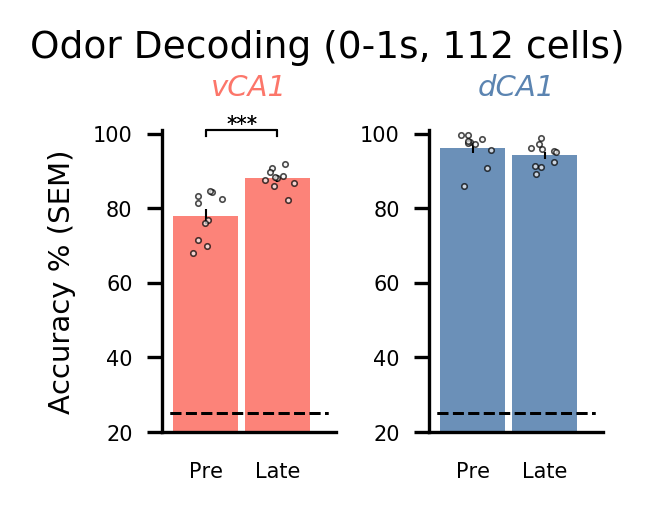

In [241]:
fig, ax = pl.subplots(1,2, figsize=(2, 1.5))
loops=10
tb='1s'
t=5 #time bin to plot (5 = 0-1s post odor delivery)
sess='post'
width=.9
for reg,r,co in zip(['vhpc','dhpc'],range(2),['#FC766AFF','#5B84B1FF']):
    for i,sess,la in zip(range(2),['expo','post'],['Pre','Post']):
        #for i,t,c,la in zip(range(2),[5,8],['k','k'],['CS','Trace']):
            ax[r].bar(i,np.mean(eval("scores_%s_%s_ncells_%s[sess][100:110]"%(tb,t,reg)))*100,width=.9,
                      color=co,alpha=.9,label=la)
            exec("s_%s_%s_%s = np.array(np.std(scores_%s_%s_ncells_%s[sess][100:110])*100/np.sqrt(loops-1))"%(t,reg,sess,tb,t,reg))
            ax[r].errorbar(i,np.mean(eval("scores_%s_%s_ncells_%s[sess][100:110]"%(tb,t,reg)))*100,yerr=eval('s_%s_%s_%s'%(t,reg,sess)),color='k')
            ax[r].scatter(i+np.random.random(loops)*width/2-width/4.5,np.array(eval("scores_%s_%s_ncells_%s[sess][100:110]"%(tb,t,reg)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
            
for x in range (2):
    for y in range(2):
        ax[x].set_ylim(20, 101)
        #ax[x].set_xlim(-5, 9)
        ax[x].hlines(25, -0.5,1.7, color='k', lw=.7, linestyles='dashed')
        #ax[x].set_xlabel('Comparison')
        ax[0].set_ylabel('Accuracy % (SEM)')
        ax[x].set_xticks([0,1])
        ax[x].set_xticklabels(['Pre','Late'])
        ax[x].tick_params(axis='x',bottom='off')

pvs=[]
sess=['expo','post']
for reg,r in zip(['vhpc','dhpc'],range(2)):
    for q in [101,101]:
        pvs.append(add_significance(ax[r], eval("scores_%s_%s_ncells_%s[sess[0]][100:110]"%(tb,t,reg)),
                    eval("scores_%s_%s_ncells_%s[sess[1]][100:110]"%(tb,t,reg)),0,1,q))
    report_stats(eval("scores_%s_%s_ncells_%s[sess[0]][100:110]"%(tb,t,reg)),
                    eval("scores_%s_%s_ncells_%s[sess[1]][100:110]"%(tb,t,reg)))
#for i,t,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),sessions[1:]):
#        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k))[-loops:],.5,i,
#               np.mean(eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('vCA1', y=1.03,color='#FC766AFF',fontstyle='italic')
ax[1].set_title('dCA1', y=1.03,color='#5B84B1FF',fontstyle='italic')
#ax[1].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Odor Decoding (0-1s, 112 cells)", fontsize=9, y=1.05)

fig.tight_layout(pad=1)

fig.savefig('../figures/%s_odor_expopost_112cells.pdf'%NOTEBOOK_NAME)

U = 19.5 p = 0.0232902349289 r = -0.515544095384
U = 37.5 p = 0.363261554225 r = -0.211288563682


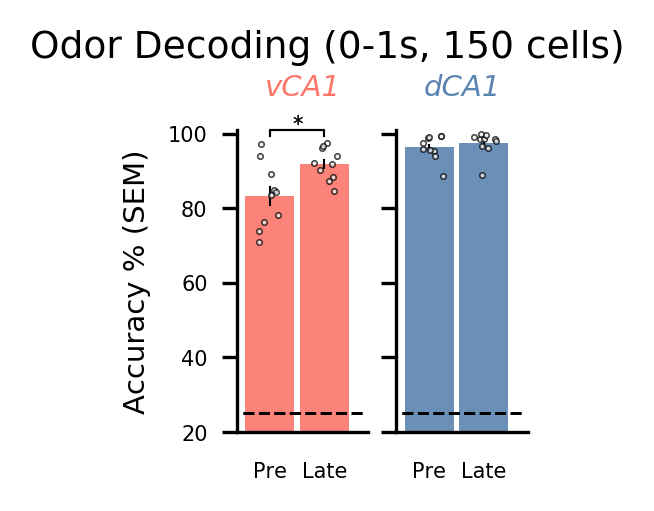

In [283]:
fig, ax = pl.subplots(1,2, figsize=(1.5, 1.5),sharey=True)
loops=10
tb='1s'
t=5 #time bin to plot (5 = 0-1s post odor delivery)
sess='post'
width=.9
for reg,r,co in zip(['vhpc','dhpc'],range(2),['#FC766AFF','#5B84B1FF']):
    for i,sess,la in zip(range(2),['expo','post'],['Pre','Post']):
        #for i,t,c,la in zip(range(2),[5,8],['k','k'],['CS','Trace']):
            ax[r].bar(i,np.mean(eval("scores_%s_%s_ncells_%s[sess][150:160]"%(tb,t,reg)))*100,width=.9,
                      color=co,alpha=.9,label=la)
            exec("s_%s_%s_%s = np.array(np.std(scores_%s_%s_ncells_%s[sess][150:160])*100/np.sqrt(loops-1))"%(t,reg,sess,tb,t,reg))
            ax[r].errorbar(i,np.mean(eval("scores_%s_%s_ncells_%s[sess][150:160]"%(tb,t,reg)))*100,yerr=eval('s_%s_%s_%s'%(t,reg,sess)),color='k')
            ax[r].scatter(i+np.random.random(loops)*width/2-width/4.5,np.array(eval("scores_%s_%s_ncells_%s[sess][150:160]"%(tb,t,reg)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
            
for x in range (2):
    for y in range(2):
        ax[x].set_ylim(20, 101)
        #ax[x].set_xlim(-5, 9)
        ax[x].hlines(25, -0.5,1.7, color='k', lw=.7, linestyles='dashed')
        #ax[x].set_xlabel('Comparison')
        ax[0].set_ylabel('Accuracy % (SEM)')
        ax[x].set_xticks([0,1])
        ax[x].set_xticklabels(['Pre','Late'])
        ax[x].tick_params(axis='x',bottom='off')

pvs=[]
sess=['expo','post']
for reg,r in zip(['vhpc','dhpc'],range(2)):
    for q in [101,101]:
        pvs.append(add_significance(ax[r], eval("scores_%s_%s_ncells_%s[sess[0]][150:160]"%(tb,t,reg)),
                    eval("scores_%s_%s_ncells_%s[sess[1]][150:160]"%(tb,t,reg)),0,1,q))
    report_stats(eval("scores_%s_%s_ncells_%s[sess[0]][150:160]"%(tb,t,reg)),
                    eval("scores_%s_%s_ncells_%s[sess[1]][150:160]"%(tb,t,reg)))
#for i,t,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),sessions[1:]):
#        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k))[-loops:],.5,i,
#               np.mean(eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('vCA1', y=1.03,color='#FC766AFF',fontstyle='italic')
ax[1].set_title('dCA1', y=1.03,color='#5B84B1FF',fontstyle='italic')
#ax[1].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Odor Decoding (0-1s, 150 cells)", fontsize=9, y=1.05)

fig.tight_layout(pad=1)

fig.savefig('../figures/%s_odor_expopost_150cells.pdf'%NOTEBOOK_NAME)

U = 19.5 p = 0.0465804698578 r = -0.515544095384
U = 31.5 p = 0.346587486339 r = -0.31270707425
U = 12.5 p = 0.0102508802281 r = -0.633865691046
U = 37.5 p = 0.72652310845 r = -0.211288563682
U = 76.0 p = 0.104027610911 r = 0.439480212459
U = 64.5 p = 0.578384238457 r = 0.245094733871


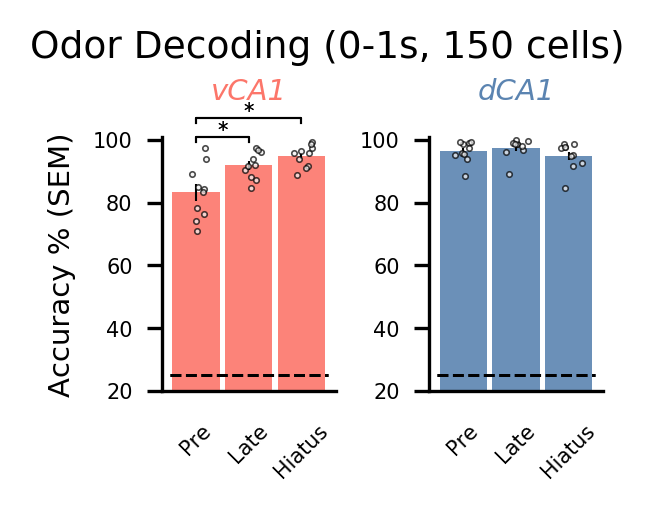

In [270]:
fig, ax = pl.subplots(1,2, figsize=(2, 1.5))
loops=10
tb='1s'
t=5 #time bin to plot (5 = 0-1s post odor delivery)
sess='post'
width=.9
for reg,r,co in zip(['vhpc','dhpc'],range(2),['#FC766AFF','#5B84B1FF']):
    for i,sess,la in zip(range(3),['expo','post','post_hiatus'],['Pre','Post','Hiatus']):
        #for i,t,c,la in zip(range(2),[5,8],['k','k'],['CS','Trace']):
            ax[r].bar(i,np.mean(eval("scores_%s_%s_ncells_%s[sess][150:160]"%(tb,t,reg)))*100,width=.9,
                      color=co,alpha=.9,label=la)
            exec("s_%s_%s_%s = np.array(np.std(scores_%s_%s_ncells_%s[sess][150:160])*100/np.sqrt(loops-1))"%(t,reg,sess,tb,t,reg))
            ax[r].errorbar(i,np.mean(eval("scores_%s_%s_ncells_%s[sess][150:160]"%(tb,t,reg)))*100,yerr=eval('s_%s_%s_%s'%(t,reg,sess)),color='k')
            ax[r].scatter(i+np.random.random(loops)*width/2-width/4.5,np.array(eval("scores_%s_%s_ncells_%s[sess][150:160]"%(tb,t,reg)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
            
for x in range (2):
    for y in range(2):
        ax[x].set_ylim(20, 101)
        #ax[x].set_xlim(-5, 9)
        ax[x].hlines(25, -0.5,2.5, color='k', lw=.7, linestyles='dashed')
        #ax[x].set_xlabel('Comparison')
        ax[0].set_ylabel('Accuracy % (SEM)')
        ax[x].set_xticks([0,1,2])
        ax[x].set_xticklabels(['Pre','Late','Hiatus'],fontsize=5,rotation=45)
        ax[x].tick_params(axis='x',bottom='off')

pvs=[]
sess=['expo','post','post_hiatus']
for reg,r in zip(['vhpc','dhpc'],range(2)):
    for q in [101,101]:
        pvs.append(add_significance(ax[r], eval("scores_%s_%s_ncells_%s[sess[0]][150:160]"%(tb,t,reg)),
                    eval("scores_%s_%s_ncells_%s[sess[1]][150:160]"%(tb,t,reg)),0,1,q,mcc=2))
        pvs.append(add_significance(ax[r], eval("scores_%s_%s_ncells_%s[sess[1]][150:160]"%(tb,t,reg)),
                    eval("scores_%s_%s_ncells_%s[sess[2]][150:160]"%(tb,t,reg)),1,2,q,mcc=2))
        pvs.append(add_significance(ax[r], eval("scores_%s_%s_ncells_%s[sess[0]][150:160]"%(tb,t,reg)),
                    eval("scores_%s_%s_ncells_%s[sess[2]][150:160]"%(tb,t,reg)),0,2,107,mcc=2))
    report_stats(eval("scores_%s_%s_ncells_%s[sess[0]][150:160]"%(tb,t,reg)),
                    eval("scores_%s_%s_ncells_%s[sess[1]][150:160]"%(tb,t,reg)),mcc=2)
    report_stats(eval("scores_%s_%s_ncells_%s[sess[1]][150:160]"%(tb,t,reg)),
                    eval("scores_%s_%s_ncells_%s[sess[2]][150:160]"%(tb,t,reg)),mcc=2)
    report_stats(eval("scores_%s_%s_ncells_%s[sess[0]][150:160]"%(tb,t,reg)),
                    eval("scores_%s_%s_ncells_%s[sess[2]][150:160]"%(tb,t,reg)),mcc=2)
#for i,t,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),sessions[1:]):
#        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k))[-loops:],.5,i,
#               np.mean(eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('vCA1', y=1.05,color='#FC766AFF',fontstyle='italic')
ax[1].set_title('dCA1', y=1.05,color='#5B84B1FF',fontstyle='italic')
#ax[1].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Odor Decoding (0-1s, 150 cells)", fontsize=9, y=1.05)

fig.tight_layout(pad=1)

fig.savefig('../figures/%s_odor_ExPoHi_150cells.pdf'%NOTEBOOK_NAME)

U = 6.0 p = 0.0010035563801 r = -0.743735744161
U = 16.0 p = 0.0112682466586 r = -0.574704893215


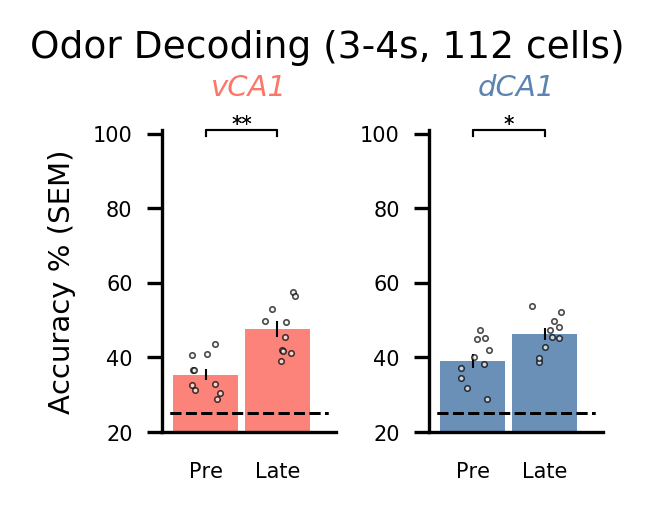

In [208]:
fig, ax = pl.subplots(1,2, figsize=(2, 1.5))
loops=10
tb='1s'
t=8 #time bin to plot (5 = 0-1s post odor delivery)
sess='post'
width=.9
for reg,r,co in zip(['vhpc','dhpc'],range(2),['#FC766AFF','#5B84B1FF']):
    for i,sess,la in zip(range(2),['expo','post'],['Pre','Post']):
        #for i,t,c,la in zip(range(2),[5,8],['k','k'],['CS','Trace']):
            ax[r].bar(i,np.mean(eval("scores_%s_%s_ncells_%s[sess][100:110]"%(tb,t,reg)))*100,width=.9,
                      color=co,alpha=.9,label=la)
            exec("s_%s_%s_%s = np.array(np.std(scores_%s_%s_ncells_%s[sess][100:110])*100/np.sqrt(loops-1))"%(t,reg,sess,tb,t,reg))
            ax[r].errorbar(i,np.mean(eval("scores_%s_%s_ncells_%s[sess][100:110]"%(tb,t,reg)))*100,yerr=eval('s_%s_%s_%s'%(t,reg,sess)),color='k')
            ax[r].scatter(i+np.random.random(loops)*width/2-width/4.5,np.array(eval("scores_%s_%s_ncells_%s[sess][100:110]"%(tb,t,reg)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
            
for x in range (2):
    for y in range(2):
        ax[x].set_ylim(20, 101)
        #ax[x].set_xlim(-5, 9)
        ax[x].hlines(25, -0.5,1.7, color='k', lw=.7, linestyles='dashed')
        #ax[x].set_xlabel('Comparison')
        ax[0].set_ylabel('Accuracy % (SEM)')
        ax[x].set_xticks([0,1])
        ax[x].set_xticklabels(['Pre','Late'])
        ax[x].tick_params(axis='x',bottom='off')

pvs=[]
sess=['expo','post']
for reg,r in zip(['vhpc','dhpc'],range(2)):
    for q in [101,101]:
        pvs.append(add_significance(ax[r], eval("scores_%s_%s_ncells_%s[sess[0]][100:110]"%(tb,t,reg)),
                    eval("scores_%s_%s_ncells_%s[sess[1]][100:110]"%(tb,t,reg)),0,1,q))
    report_stats(eval("scores_%s_%s_ncells_%s[sess[0]][100:110]"%(tb,t,reg)),
                    eval("scores_%s_%s_ncells_%s[sess[1]][100:110]"%(tb,t,reg)))
#for i,t,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),sessions[1:]):
#        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k))[-loops:],.5,i,
#               np.mean(eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('vCA1', y=1.03,color='#FC766AFF',fontstyle='italic')
ax[1].set_title('dCA1', y=1.03,color='#5B84B1FF',fontstyle='italic')
#ax[1].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Odor Decoding (3-4s, 112 cells)", fontsize=9, y=1.05)

fig.tight_layout(pad=1)

fig.savefig('../figures/%s_trace_expopost_112cells.pdf'%NOTEBOOK_NAME)

U = 19.5 p = 0.0231864266968 r = -0.515544095384
U = 16.0 p = 0.0112682466586 r = -0.574704893215


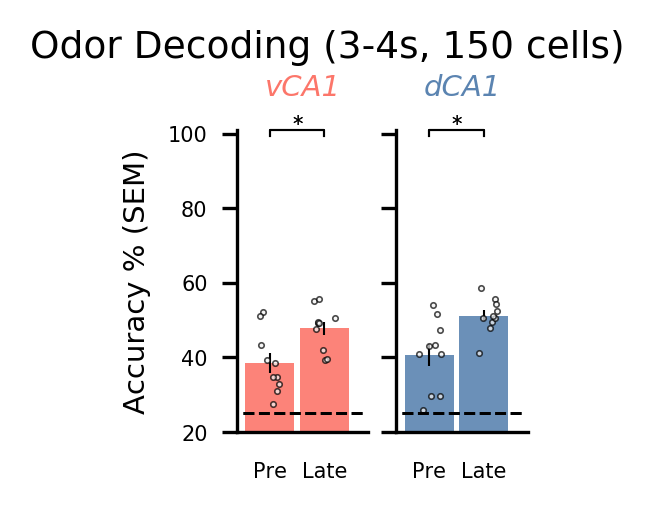

In [282]:
fig, ax = pl.subplots(1,2, figsize=(1.5, 1.5),sharey=True)
loops=10
tb='1s'
t=8 #time bin to plot (5 = 0-1s post odor delivery)
sess='post'
width=.9
for reg,r,co in zip(['vhpc','dhpc'],range(2),['#FC766AFF','#5B84B1FF']):
    for i,sess,la in zip(range(2),['expo','post'],['Pre','Post']):
        #for i,t,c,la in zip(range(2),[5,8],['k','k'],['CS','Trace']):
            ax[r].bar(i,np.mean(eval("scores_%s_%s_ncells_%s[sess][140:150]"%(tb,t,reg)))*100,width=.9,
                      color=co,alpha=.9,label=la)
            exec("s_%s_%s_%s = np.array(np.std(scores_%s_%s_ncells_%s[sess][140:150])*100/np.sqrt(loops-1))"%(t,reg,sess,tb,t,reg))
            ax[r].errorbar(i,np.mean(eval("scores_%s_%s_ncells_%s[sess][140:150]"%(tb,t,reg)))*100,yerr=eval('s_%s_%s_%s'%(t,reg,sess)),color='k')
            ax[r].scatter(i+np.random.random(loops)*width/2-width/4.5,np.array(eval("scores_%s_%s_ncells_%s[sess][140:150]"%(tb,t,reg)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
            
for x in range (2):
    for y in range(2):
        ax[x].set_ylim(20, 101)
        #ax[x].set_xlim(-5, 9)
        ax[x].hlines(25, -0.5,1.7, color='k', lw=.7, linestyles='dashed')
        #ax[x].set_xlabel('Comparison')
        ax[0].set_ylabel('Accuracy % (SEM)')
        ax[x].set_xticks([0,1])
        ax[x].set_xticklabels(['Pre','Late'])
        ax[x].tick_params(axis='x',bottom='off')

pvs=[]
sess=['expo','post']
for reg,r in zip(['vhpc','dhpc'],range(2)):
    for q in [101,101]:
        pvs.append(add_significance(ax[r], eval("scores_%s_%s_ncells_%s[sess[0]][140:150]"%(tb,t,reg)),
                    eval("scores_%s_%s_ncells_%s[sess[1]][140:150]"%(tb,t,reg)),0,1,q))
    report_stats(eval("scores_%s_%s_ncells_%s[sess[0]][140:150]"%(tb,t,reg)),
                    eval("scores_%s_%s_ncells_%s[sess[1]][140:150]"%(tb,t,reg)))
#for i,t,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),sessions[1:]):
#        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k))[-loops:],.5,i,
#               np.mean(eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('vCA1', y=1.03,color='#FC766AFF',fontstyle='italic')
ax[1].set_title('dCA1', y=1.03,color='#5B84B1FF',fontstyle='italic')
#ax[1].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Odor Decoding (3-4s, 150 cells)", fontsize=9, y=1.05)

fig.tight_layout(pad=1)

fig.savefig('../figures/%s_trace_expopost_150cells.pdf'%NOTEBOOK_NAME)

U = 19.5 p = 0.0463728533936 r = -0.515544095384
U = 57.5 p = 1.19174150007 r = 0.126773138209
U = 18.0 p = 0.0343473219921 r = -0.540898723026
U = 16.0 p = 0.0225364933172 r = -0.574704893215
U = 58.0 p = 1.14063059195 r = 0.135224680757
U = 27.0 p = 0.176504646242 r = -0.388770957175


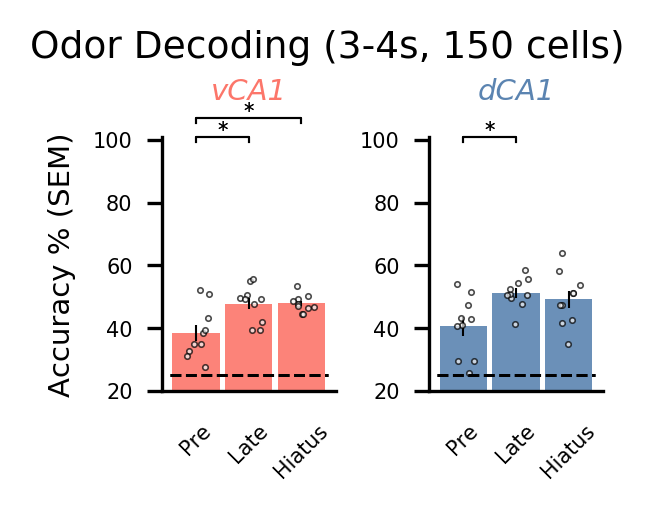

In [269]:
fig, ax = pl.subplots(1,2, figsize=(2, 1.5))
loops=10
tb='1s'
t=8 #time bin to plot (5 = 0-1s post odor delivery)
width=.9
for reg,r,co in zip(['vhpc','dhpc'],range(2),['#FC766AFF','#5B84B1FF']):
    for i,sess,la in zip(range(3),['expo','post','post_hiatus'],['Pre','Post','Hiatus']):
        #for i,t,c,la in zip(range(2),[5,8],['k','k'],['CS','Trace']):
            ax[r].bar(i,np.mean(eval("scores_%s_%s_ncells_%s[sess][140:150]"%(tb,t,reg)))*100,width=.9,
                      color=co,alpha=.9,label=la)
            exec("s_%s_%s_%s = np.array(np.std(scores_%s_%s_ncells_%s[sess][140:150])*100/np.sqrt(loops-1))"%(t,reg,sess,tb,t,reg))
            ax[r].errorbar(i,np.mean(eval("scores_%s_%s_ncells_%s[sess][140:150]"%(tb,t,reg)))*100,yerr=eval('s_%s_%s_%s'%(t,reg,sess)),color='k')
            ax[r].scatter(i+np.random.random(loops)*width/2-width/4.5,np.array(eval("scores_%s_%s_ncells_%s[sess][140:150]"%(tb,t,reg)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
            
for x in range (2):
    for y in range(2):
        ax[x].set_ylim(20, 101)
        #ax[x].set_xlim(-5, 9)
        ax[x].hlines(25, -0.5,2.5, color='k', lw=.7, linestyles='dashed')
        #ax[x].set_xlabel('Comparison')
        ax[0].set_ylabel('Accuracy % (SEM)')
        ax[x].set_xticks([0,1,2])
        ax[x].set_xticklabels(['Pre','Late','Hiatus'],fontsize=5,rotation=45)
        ax[x].tick_params(axis='x',bottom='off')

pvs=[]
sess=['expo','post','post_hiatus']
for reg,r in zip(['vhpc','dhpc'],range(2)):
    for q in [101,101]:
        pvs.append(add_significance(ax[r], eval("scores_%s_%s_ncells_%s[sess[0]][140:150]"%(tb,t,reg)),
                    eval("scores_%s_%s_ncells_%s[sess[1]][140:150]"%(tb,t,reg)),0,1,q,mcc=2))
        pvs.append(add_significance(ax[r], eval("scores_%s_%s_ncells_%s[sess[1]][140:150]"%(tb,t,reg)),
                    eval("scores_%s_%s_ncells_%s[sess[2]][140:150]"%(tb,t,reg)),1,2,q,mcc=2))
        pvs.append(add_significance(ax[r], eval("scores_%s_%s_ncells_%s[sess[0]][140:150]"%(tb,t,reg)),
                    eval("scores_%s_%s_ncells_%s[sess[2]][140:150]"%(tb,t,reg)),0,2,107,mcc=2))
    report_stats(eval("scores_%s_%s_ncells_%s[sess[0]][140:150]"%(tb,t,reg)),
                    eval("scores_%s_%s_ncells_%s[sess[1]][140:150]"%(tb,t,reg)),mcc=2)
    report_stats(eval("scores_%s_%s_ncells_%s[sess[1]][140:150]"%(tb,t,reg)),
                    eval("scores_%s_%s_ncells_%s[sess[2]][140:150]"%(tb,t,reg)),mcc=2)
    report_stats(eval("scores_%s_%s_ncells_%s[sess[0]][140:150]"%(tb,t,reg)),
                    eval("scores_%s_%s_ncells_%s[sess[2]][140:150]"%(tb,t,reg)),mcc=2)

ax[0].set_title('vCA1', y=1.05,color='#FC766AFF',fontstyle='italic')
ax[1].set_title('dCA1', y=1.05,color='#5B84B1FF',fontstyle='italic')
pl.suptitle("Odor Decoding (3-4s, 150 cells)", fontsize=9, y=1.05)

fig.tight_layout(pad=1)

fig.savefig('../figures/%s_trace_ExPoHi_150cells.pdf'%NOTEBOOK_NAME)

U = 25.0 p = 0.0630231794221 r = -0.422577127364
U = 68.0 p = 0.155556666533 r = 0.304255531702


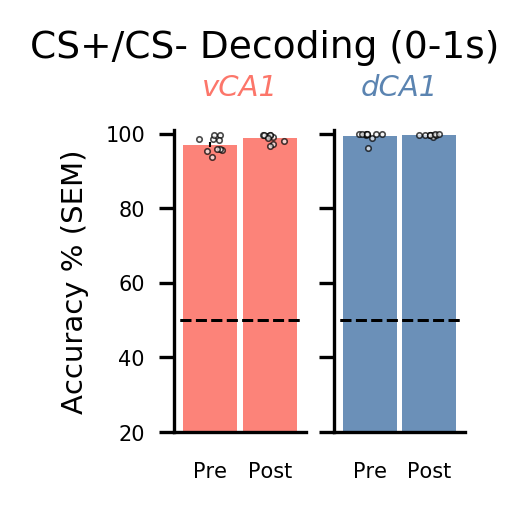

In [276]:
fig, ax = pl.subplots(1,2, figsize=(1.5, 1.5),sharey=True)
loops=10
tb='1s'
t=5 #time bin to plot (5 = 0-1s post odor delivery)
width=.9
for reg,r,co in zip(['vhpc','dhpc'],range(2),['#FC766AFF','#5B84B1FF']):
    for i,sess,la in zip(range(2),['expo','post'],['Pre','Post']):
        #for i,t,c,la in zip(range(2),[5,8],['k','k'],['CS','Trace']):
            ax[r].bar(i,np.mean(eval("scores_cspm_%s_%s_%s[sess][-loops:]"%(tb,t,reg)))*100,width=.9,
                      color=co,alpha=.9,label=la)
            exec("s_%s_%s_%s = np.array(np.std(scores_cspm_%s_%s_%s[sess][-loops:])*100/np.sqrt(loops-1))"%(t,reg,sess,tb,t,reg))
            ax[r].errorbar(i,np.mean(eval("scores_cspm_%s_%s_%s[sess][-loops:]"%(tb,t,reg)))*100,yerr=eval('s_%s_%s_%s'%(t,reg,sess)),color='k')
            ax[r].scatter(i+np.random.random(loops)*width/2-width/4.5,np.array(eval("scores_cspm_%s_%s_%s[sess][-loops:]"%(tb,t,reg)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
            
for x in range (2):
    for y in range(2):
        ax[x].set_ylim(20, 101)
        #ax[x].set_xlim(-5, 9)
        ax[x].hlines(50, -0.5,1.5, color='k', lw=.7, linestyles='dashed')
        #ax[x].set_xlabel('Comparison')
        ax[0].set_ylabel('Accuracy % (SEM)')
        ax[x].set_xticks([0,1])
        ax[x].set_xticklabels(['Pre','Post'])
        ax[x].tick_params(axis='x',bottom='off')

pvs=[]
sess=['expo','post']
for reg,r in zip(['vhpc','dhpc'],range(2)):
    for q in [101,101]:
        pvs.append(add_significance(ax[r], eval("scores_cspm_%s_%s_%s[sess[0]][-loops:]"%(tb,t,reg)),
                    eval("scores_cspm_%s_%s_%s[sess[1]][-loops:]"%(tb,t,reg)),0,1,q))
    report_stats(eval("scores_cspm_%s_%s_%s[sess[0]][-loops:]"%(tb,t,reg)),
                    eval("scores_cspm_%s_%s_%s[sess[1]][-loops:]"%(tb,t,reg)))
#for i,t,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),sessions[1:]):
#        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k))[-loops:],.5,i,
#               np.mean(eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('vCA1', y=1.03,color='#FC766AFF',fontstyle='italic')
ax[1].set_title('dCA1', y=1.03,color='#5B84B1FF',fontstyle='italic')
#ax[1].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("CS+/CS- Decoding (0-1s)", fontsize=9, y=1.05)

fig.tight_layout(pad=1)

fig.savefig('../figures/%s_cspm_during_odor_prepost.pdf'%NOTEBOOK_NAME)

U = 7.0 p = 0.00128748883785 r = -0.726832659067
U = 69.0 p = 0.161024657106 r = 0.321158616797


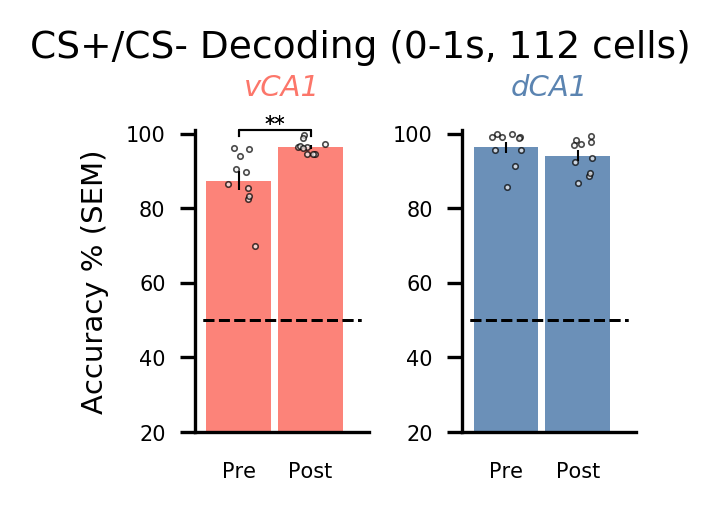

In [207]:
fig, ax = pl.subplots(1,2, figsize=(2, 1.5))
loops=10
tb='1s'
t=5 #time bin to plot (5 = 0-1s post odor delivery)
sess='post'
width=.9
for reg,r,co in zip(['vhpc','dhpc'],range(2),['#FC766AFF','#5B84B1FF']):
    for i,sess,la in zip(range(2),['expo','post'],['Pre','Post']):
        #for i,t,c,la in zip(range(2),[5,8],['k','k'],['CS','Trace']):
            ax[r].bar(i,np.mean(eval("scores_cspm_%s_%s_ncells_%s[sess][100:110]"%(tb,t,reg)))*100,width=.9,
                      color=co,alpha=.9,label=la)
            exec("s_%s_%s_%s = np.array(np.std(scores_cspm_%s_%s_ncells_%s[sess][100:110])*100/np.sqrt(loops-1))"%(t,reg,sess,tb,t,reg))
            ax[r].errorbar(i,np.mean(eval("scores_cspm_%s_%s_ncells_%s[sess][100:110]"%(tb,t,reg)))*100,yerr=eval('s_%s_%s_%s'%(t,reg,sess)),color='k')
            ax[r].scatter(i+np.random.random(loops)*width/2-width/4.5,np.array(eval("scores_cspm_%s_%s_ncells_%s[sess][100:110]"%(tb,t,reg)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
            
for x in range (2):
    for y in range(2):
        ax[x].set_ylim(20, 101)
        #ax[x].set_xlim(-5, 9)
        ax[x].hlines(50, -0.5,1.7, color='k', lw=.7, linestyles='dashed')
        #ax[x].set_xlabel('Comparison')
        ax[0].set_ylabel('Accuracy % (SEM)')
        ax[x].set_xticks([0,1])
        ax[x].set_xticklabels(['Pre','Post'])
        ax[x].tick_params(axis='x',bottom='off')

pvs=[]
sess=['expo','post']
for reg,r in zip(['vhpc','dhpc'],range(2)):
    for q in [101,101]:
        pvs.append(add_significance(ax[r], eval("scores_cspm_%s_%s_ncells_%s[sess[0]][100:110]"%(tb,t,reg)),
                    eval("scores_cspm_%s_%s_ncells_%s[sess[1]][100:110]"%(tb,t,reg)),0,1,q))
    report_stats(eval("scores_cspm_%s_%s_ncells_%s[sess[0]][100:110]"%(tb,t,reg)),
                    eval("scores_cspm_%s_%s_ncells_%s[sess[1]][100:110]"%(tb,t,reg)))
#for i,t,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),sessions[1:]):
#        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k))[-loops:],.5,i,
#               np.mean(eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('vCA1', y=1.03,color='#FC766AFF',fontstyle='italic')
ax[1].set_title('dCA1', y=1.03,color='#5B84B1FF',fontstyle='italic')
#ax[1].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("CS+/CS- Decoding (0-1s, 112 cells)", fontsize=9, y=1.05)

fig.tight_layout(pad=1)

fig.savefig('../figures/%s_cspm_odor_expopost_112cells.pdf'%NOTEBOOK_NAME)

U = 11.5 p = 0.00403036661885 r = -0.650768776141
U = 50.0 p = 0.969724577788 r = 0.0


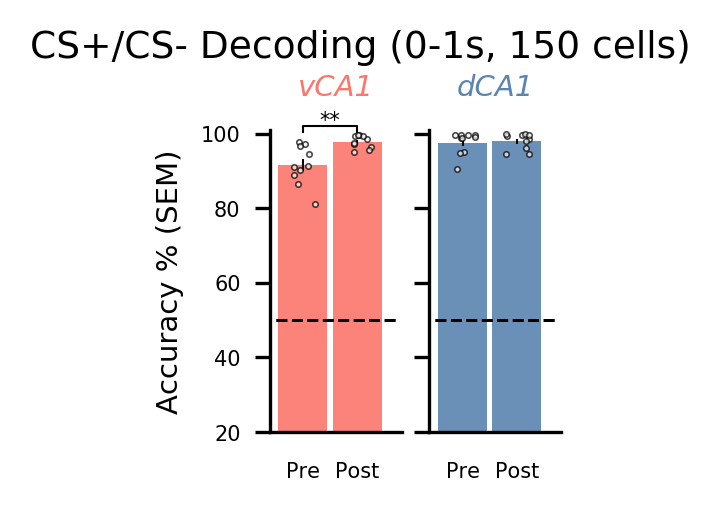

In [279]:
fig, ax = pl.subplots(1,2, figsize=(1.5, 1.5),sharey=True)
loops=10
tb='1s'
t=5 #time bin to plot (5 = 0-1s post odor delivery)
sess='post'
width=.9
for reg,r,co in zip(['vhpc','dhpc'],range(2),['#FC766AFF','#5B84B1FF']):
    for i,sess,la in zip(range(2),['expo','post'],['Pre','Post']):
        #for i,t,c,la in zip(range(2),[5,8],['k','k'],['CS','Trace']):
            ax[r].bar(i,np.mean(eval("scores_cspm_%s_%s_ncells_%s[sess][150:160]"%(tb,t,reg)))*100,width=.9,
                      color=co,alpha=.9,label=la)
            exec("s_%s_%s_%s = np.array(np.std(scores_cspm_%s_%s_ncells_%s[sess][150:160])*100/np.sqrt(loops-1))"%(t,reg,sess,tb,t,reg))
            ax[r].errorbar(i,np.mean(eval("scores_cspm_%s_%s_ncells_%s[sess][150:160]"%(tb,t,reg)))*100,yerr=eval('s_%s_%s_%s'%(t,reg,sess)),color='k')
            ax[r].scatter(i+np.random.random(loops)*width/2-width/4.5,np.array(eval("scores_cspm_%s_%s_ncells_%s[sess][150:160]"%(tb,t,reg)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
            
for x in range (2):
    for y in range(2):
        ax[x].set_ylim(20, 101)
        #ax[x].set_xlim(-5, 9)
        ax[x].hlines(50, -0.5,1.7, color='k', lw=.7, linestyles='dashed')
        #ax[x].set_xlabel('Comparison')
        ax[0].set_ylabel('Accuracy % (SEM)')
        ax[x].set_xticks([0,1])
        ax[x].set_xticklabels(['Pre','Post'])
        ax[x].tick_params(axis='x',bottom='off')

pvs=[]
sess=['expo','post']
for reg,r in zip(['vhpc','dhpc'],range(2)):
    for q in [102]:
        pvs.append(add_significance(ax[r], eval("scores_cspm_%s_%s_ncells_%s[sess[0]][150:160]"%(tb,t,reg)),
                    eval("scores_cspm_%s_%s_ncells_%s[sess[1]][150:160]"%(tb,t,reg)),0,1,q))
    report_stats(eval("scores_cspm_%s_%s_ncells_%s[sess[0]][150:160]"%(tb,t,reg)),
                    eval("scores_cspm_%s_%s_ncells_%s[sess[1]][150:160]"%(tb,t,reg)))
#for i,t,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),sessions[1:]):
#        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k))[-loops:],.5,i,
#               np.mean(eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('vCA1', y=1.03,color='#FC766AFF',fontstyle='italic')
ax[1].set_title('dCA1', y=1.03,color='#5B84B1FF',fontstyle='italic')
#ax[1].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("CS+/CS- Decoding (0-1s, 150 cells)", fontsize=9, y=1.05)

fig.tight_layout(pad=1)

fig.savefig('../figures/%s_cspm_odor_expopost_150cells.pdf'%NOTEBOOK_NAME)

U = 0.0 p = 0.000180634720808 r = -0.845154254729
U = 30.0 p = 0.14031583347 r = -0.338061701891


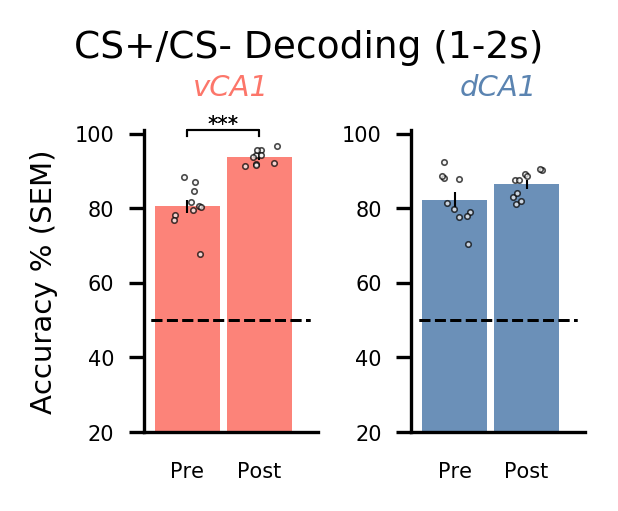

In [221]:
fig, ax = pl.subplots(1,2, figsize=(2, 1.5))
loops=10
tb='1s'
t=6 #time bin to plot (5 = 0-1s post odor delivery)
sess='post'
width=.9
for reg,r,co in zip(['vhpc','dhpc'],range(2),['#FC766AFF','#5B84B1FF']):
    for i,sess,la in zip(range(2),['expo','post'],['Pre','Post']):
        #for i,t,c,la in zip(range(2),[5,8],['k','k'],['CS','Trace']):
            ax[r].bar(i,np.mean(eval("scores_cspm_%s_%s_%s[sess][-loops:]"%(tb,t,reg)))*100,width=.9,
                      color=co,alpha=.9,label=la)
            exec("s_%s_%s_%s = np.array(np.std(scores_cspm_%s_%s_%s[sess][-loops:])*100/np.sqrt(loops-1))"%(t,reg,sess,tb,t,reg))
            ax[r].errorbar(i,np.mean(eval("scores_cspm_%s_%s_%s[sess][-loops:]"%(tb,t,reg)))*100,yerr=eval('s_%s_%s_%s'%(t,reg,sess)),color='k')
            ax[r].scatter(i+np.random.random(loops)*width/2-width/4.5,np.array(eval("scores_cspm_%s_%s_%s[sess][-loops:]"%(tb,t,reg)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
            
for x in range (2):
    for y in range(2):
        ax[x].set_ylim(20, 101)
        #ax[x].set_xlim(-5, 9)
        ax[x].hlines(50, -0.5,1.7, color='k', lw=.7, linestyles='dashed')
        #ax[x].set_xlabel('Comparison')
        ax[0].set_ylabel('Accuracy % (SEM)')
        ax[x].set_xticks([0,1])
        ax[x].set_xticklabels(['Pre','Post'])
        ax[x].tick_params(axis='x',bottom='off')

pvs=[]
sess=['expo','post']
for reg,r in zip(['vhpc','dhpc'],range(2)):
    for q in [101,101]:
        pvs.append(add_significance(ax[r], eval("scores_cspm_%s_%s_%s[sess[0]][-loops:]"%(tb,t,reg)),
                    eval("scores_cspm_%s_%s_%s[sess[1]][-loops:]"%(tb,t,reg)),0,1,q))
    report_stats(eval("scores_cspm_%s_%s_%s[sess[0]][-loops:]"%(tb,t,reg)),
                    eval("scores_cspm_%s_%s_%s[sess[1]][-loops:]"%(tb,t,reg)))
#for i,t,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),sessions[1:]):
#        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k))[-loops:],.5,i,
#               np.mean(eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('vCA1', y=1.03,color='#FC766AFF',fontstyle='italic')
ax[1].set_title('dCA1', y=1.03,color='#5B84B1FF',fontstyle='italic')
#ax[1].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("CS+/CS- Decoding (1-2s)", fontsize=9, y=1.05)

fig.tight_layout(pad=1)

#fig.savefig('../figures/%s_cspm_during_odor_prepost.pdf'%NOTEBOOK_NAME)

U = 0.0 p = 0.000181651146091 r = -0.845154254729
U = 0.0 p = 0.000181651146091 r = -0.845154254729


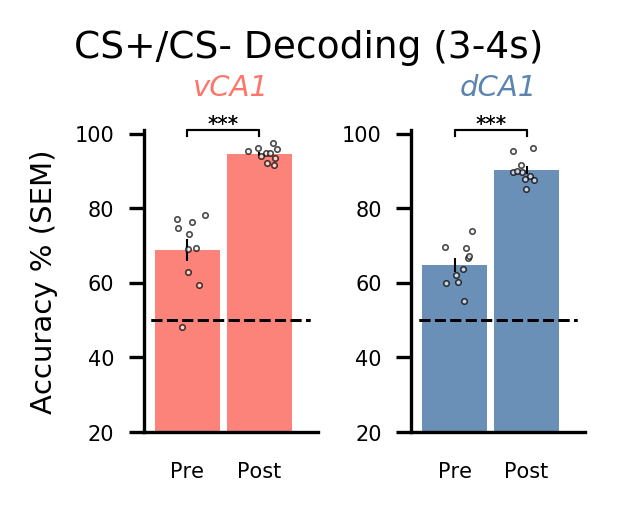

In [186]:
fig, ax = pl.subplots(1,2, figsize=(2, 1.5))
loops=10
tb='1s'
t=8 #time bin to plot (5 = 0-1s post odor delivery)
sess='post'
width=.9
for reg,r,co in zip(['vhpc','dhpc'],range(2),['#FC766AFF','#5B84B1FF']):
    for i,sess,la in zip(range(2),['expo','post'],['Pre','Post']):
        #for i,t,c,la in zip(range(2),[5,8],['k','k'],['CS','Trace']):
            ax[r].bar(i,np.mean(eval("scores_cspm_%s_%s_%s[sess][-loops:]"%(tb,t,reg)))*100,width=.9,
                      color=co,alpha=.9,label=la)
            exec("s_%s_%s_%s = np.array(np.std(scores_cspm_%s_%s_%s[sess][-loops:])*100/np.sqrt(loops-1))"%(t,reg,sess,tb,t,reg))
            ax[r].errorbar(i,np.mean(eval("scores_cspm_%s_%s_%s[sess][-loops:]"%(tb,t,reg)))*100,yerr=eval('s_%s_%s_%s'%(t,reg,sess)),color='k')
            ax[r].scatter(i+np.random.random(loops)*width/2-width/4.5,np.array(eval("scores_cspm_%s_%s_%s[sess][-loops:]"%(tb,t,reg)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
            
for x in range (2):
    for y in range(2):
        ax[x].set_ylim(20, 101)
        #ax[x].set_xlim(-5, 9)
        ax[x].hlines(50, -0.5,1.7, color='k', lw=.7, linestyles='dashed')
        #ax[x].set_xlabel('Comparison')
        ax[0].set_ylabel('Accuracy % (SEM)')
        ax[x].set_xticks([0,1])
        ax[x].set_xticklabels(['Pre','Post'])
        ax[x].tick_params(axis='x',bottom='off')

pvs=[]
sess=['expo','post']
for reg,r in zip(['vhpc','dhpc'],range(2)):
    for q in [101,101]:
        pvs.append(add_significance(ax[r], eval("scores_cspm_%s_%s_%s[sess[0]][-loops:]"%(tb,t,reg)),
                    eval("scores_cspm_%s_%s_%s[sess[1]][-loops:]"%(tb,t,reg)),0,1,q))
    report_stats(eval("scores_cspm_%s_%s_%s[sess[0]][-loops:]"%(tb,t,reg)),
                    eval("scores_cspm_%s_%s_%s[sess[1]][-loops:]"%(tb,t,reg)))
#for i,t,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),sessions[1:]):
#        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k))[-loops:],.5,i,
#               np.mean(eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('vCA1', y=1.03,color='#FC766AFF',fontstyle='italic')
ax[1].set_title('dCA1', y=1.03,color='#5B84B1FF',fontstyle='italic')
#ax[1].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("CS+/CS- Decoding (3-4s)", fontsize=9, y=1.05)

fig.tight_layout(pad=1)

#fig.savefig('../figures/%s_cspm_during_odor_prepost.pdf'%NOTEBOOK_NAME)

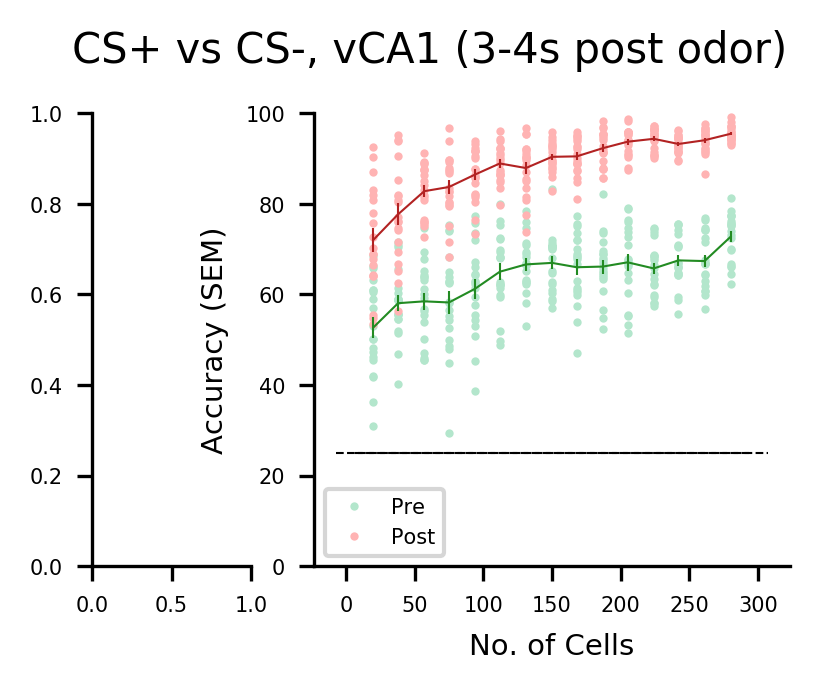

In [189]:
fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})
loops=20
sess1='expo'
sess2='post'
tb=8
plot_scores_vs_ncells(eval("ncells_1s_%s_vhpc[sess1]"%tb), eval("scores_cspm_1s_%s_ncells_vhpc"%tb)[sess1], dot_color=(0.7, 0.9, .8),label='Pre', color=dark_co[0], chance=25, ax=axs[1], labels=False)
plot_scores_vs_ncells(eval("ncells_1s_%s_vhpc[sess2]"%tb), eval("scores_cspm_1s_%s_ncells_vhpc"%tb)[sess2], ax=axs[1], color=dark_co[2],chance=25, labels=False,label='Post')
axs[1].legend()
axs[1].set_xlabel("No. of Cells")
axs[1].set_ylabel("Accuracy (SEM)")
fig.suptitle("CS+ vs CS-, vCA1 (3-4s post odor)", fontsize=10,y=1.02)

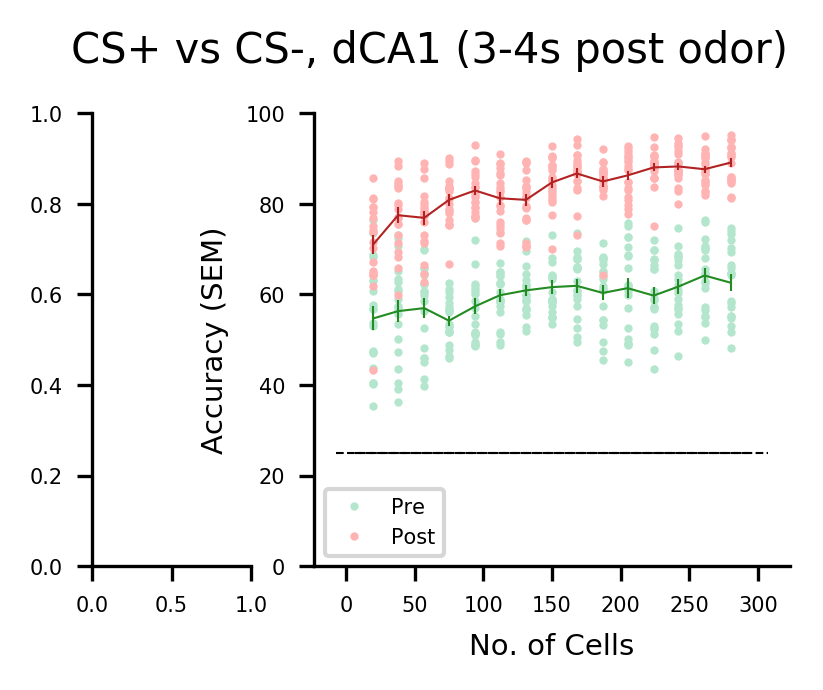

In [190]:
fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})
loops=20
sess1='expo'
sess2='post'
tb=8
plot_scores_vs_ncells(eval("ncells_1s_%s_dhpc[sess1]"%tb), eval("scores_cspm_1s_%s_ncells_dhpc"%tb)[sess1], dot_color=(0.7, 0.9, .8),label='Pre', color=dark_co[0], chance=25, ax=axs[1], labels=False)
plot_scores_vs_ncells(eval("ncells_1s_%s_dhpc[sess2]"%tb), eval("scores_cspm_1s_%s_ncells_dhpc"%tb)[sess2], ax=axs[1], color=dark_co[2],chance=25, labels=False,label='Post')
axs[1].legend()
axs[1].set_xlabel("No. of Cells")
axs[1].set_ylabel("Accuracy (SEM)")
fig.suptitle("CS+ vs CS-, dCA1 (3-4s post odor)", fontsize=10,y=1.02)

U = 0.0 p = 0.00018267179111 r = -0.845154254729
U = 1.0 p = 0.000246128127905 r = -0.828251169634


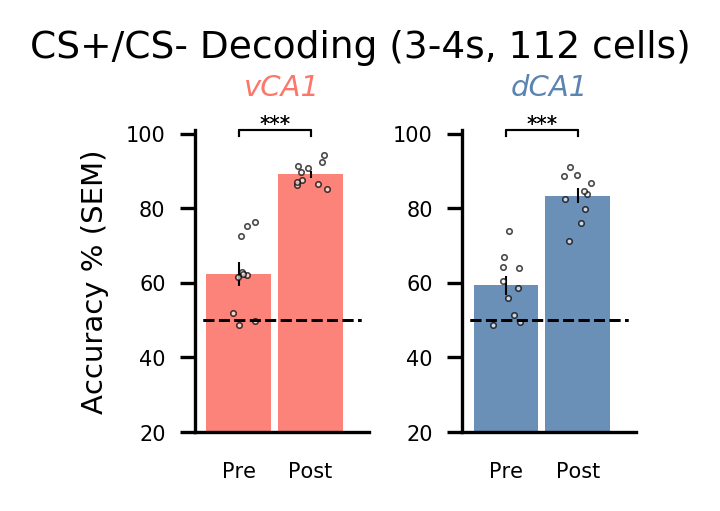

In [205]:
fig, ax = pl.subplots(1,2, figsize=(2, 1.5))
loops=10
tb='1s'
t=8 #time bin to plot (5 = 0-1s post odor delivery)
sess='post'
width=.9
for reg,r,co in zip(['vhpc','dhpc'],range(2),['#FC766AFF','#5B84B1FF']):
    for i,sess,la in zip(range(2),['expo','post'],['Pre','Post']):
        #for i,t,c,la in zip(range(2),[5,8],['k','k'],['CS','Trace']):
            ax[r].bar(i,np.mean(eval("scores_cspm_%s_%s_ncells_%s[sess][100:110]"%(tb,t,reg)))*100,width=.9,
                      color=co,alpha=.9,label=la)
            exec("s_%s_%s_%s = np.array(np.std(scores_cspm_%s_%s_ncells_%s[sess][100:110])*100/np.sqrt(loops-1))"%(t,reg,sess,tb,t,reg))
            ax[r].errorbar(i,np.mean(eval("scores_cspm_%s_%s_ncells_%s[sess][100:110]"%(tb,t,reg)))*100,yerr=eval('s_%s_%s_%s'%(t,reg,sess)),color='k')
            ax[r].scatter(i+np.random.random(loops)*width/2-width/4.5,np.array(eval("scores_cspm_%s_%s_ncells_%s[sess][100:110]"%(tb,t,reg)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
            
for x in range (2):
    for y in range(2):
        ax[x].set_ylim(20, 101)
        #ax[x].set_xlim(-5, 9)
        ax[x].hlines(50, -0.5,1.7, color='k', lw=.7, linestyles='dashed')
        #ax[x].set_xlabel('Comparison')
        ax[0].set_ylabel('Accuracy % (SEM)')
        ax[x].set_xticks([0,1])
        ax[x].set_xticklabels(['Pre','Post'])
        ax[x].tick_params(axis='x',bottom='off')

pvs=[]
sess=['expo','post']
for reg,r in zip(['vhpc','dhpc'],range(2)):
    for q in [101,101]:
        pvs.append(add_significance(ax[r], eval("scores_cspm_%s_%s_ncells_%s[sess[0]][100:110]"%(tb,t,reg)),
                    eval("scores_cspm_%s_%s_ncells_%s[sess[1]][100:110]"%(tb,t,reg)),0,1,q))
    report_stats(eval("scores_cspm_%s_%s_ncells_%s[sess[0]][100:110]"%(tb,t,reg)),
                    eval("scores_cspm_%s_%s_ncells_%s[sess[1]][100:110]"%(tb,t,reg)))
#for i,t,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),sessions[1:]):
#        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k))[-loops:],.5,i,
#               np.mean(eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('vCA1', y=1.03,color='#FC766AFF',fontstyle='italic')
ax[1].set_title('dCA1', y=1.03,color='#5B84B1FF',fontstyle='italic')
#ax[1].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("CS+/CS- Decoding (3-4s, 112 cells)", fontsize=9, y=1.05)

fig.tight_layout(pad=1)

fig.savefig('../figures/%s_cspm_tr_expopost_112cells.pdf'%NOTEBOOK_NAME)

U = 1.0 p = 0.000244804824524 r = -0.828251169634
U = 0.0 p = 0.000181651146091 r = -0.845154254729


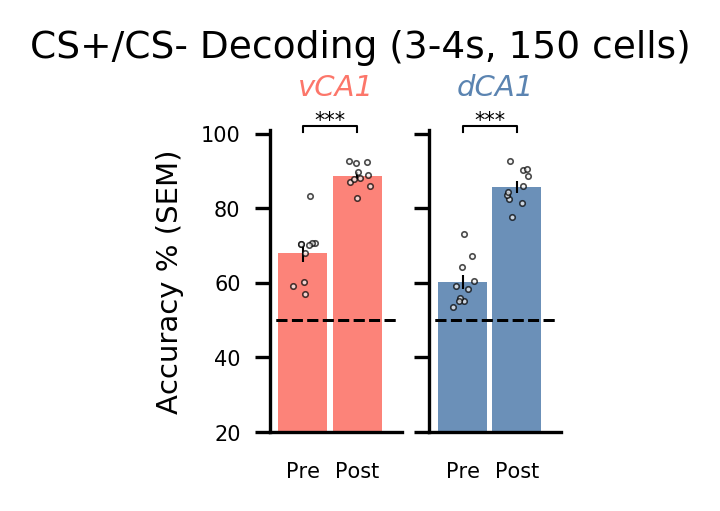

In [281]:
fig, ax = pl.subplots(1,2, figsize=(1.5, 1.5),sharey=True)
loops=10
tb='1s'
t=8 #time bin to plot (5 = 0-1s post odor delivery)
sess='post'
width=.9
for reg,r,co in zip(['vhpc','dhpc'],range(2),['#FC766AFF','#5B84B1FF']):
    for i,sess,la in zip(range(2),['expo','post'],['Pre','Post']):
        #for i,t,c,la in zip(range(2),[5,8],['k','k'],['CS','Trace']):
            ax[r].bar(i,np.mean(eval("scores_cspm_%s_%s_ncells_%s[sess][150:160]"%(tb,t,reg)))*100,width=.9,
                      color=co,alpha=.9,label=la)
            exec("s_%s_%s_%s = np.array(np.std(scores_cspm_%s_%s_ncells_%s[sess][150:160])*100/np.sqrt(loops-1))"%(t,reg,sess,tb,t,reg))
            ax[r].errorbar(i,np.mean(eval("scores_cspm_%s_%s_ncells_%s[sess][150:160]"%(tb,t,reg)))*100,yerr=eval('s_%s_%s_%s'%(t,reg,sess)),color='k')
            ax[r].scatter(i+np.random.random(loops)*width/2-width/4.5,np.array(eval("scores_cspm_%s_%s_ncells_%s[sess][150:160]"%(tb,t,reg)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
            
for x in range (2):
    for y in range(2):
        ax[x].set_ylim(20, 101)
        #ax[x].set_xlim(-5, 9)
        ax[x].hlines(50, -0.5,1.7, color='k', lw=.7, linestyles='dashed')
        #ax[x].set_xlabel('Comparison')
        ax[0].set_ylabel('Accuracy % (SEM)')
        ax[x].set_xticks([0,1])
        ax[x].set_xticklabels(['Pre','Post'])
        ax[x].tick_params(axis='x',bottom='off')

pvs=[]
sess=['expo','post']
for reg,r in zip(['vhpc','dhpc'],range(2)):
    for q in [102]:
        pvs.append(add_significance(ax[r], eval("scores_cspm_%s_%s_ncells_%s[sess[0]][150:160]"%(tb,t,reg)),
                    eval("scores_cspm_%s_%s_ncells_%s[sess[1]][150:160]"%(tb,t,reg)),0,1,q))
    report_stats(eval("scores_cspm_%s_%s_ncells_%s[sess[0]][150:160]"%(tb,t,reg)),
                    eval("scores_cspm_%s_%s_ncells_%s[sess[1]][150:160]"%(tb,t,reg)))
#for i,t,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),sessions[1:]):
#        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k))[-loops:],.5,i,
#               np.mean(eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('vCA1', y=1.03,color='#FC766AFF',fontstyle='italic')
ax[1].set_title('dCA1', y=1.03,color='#5B84B1FF',fontstyle='italic')
#ax[1].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("CS+/CS- Decoding (3-4s, 150 cells)", fontsize=9, y=1.05)

fig.tight_layout(pad=1)

fig.savefig('../figures/%s_cspm_trace_expopost_150cells.pdf'%NOTEBOOK_NAME)

U = 19.5 p = 0.0452370148417 r = -0.515544095384
U = 38.0 p = 0.76395083072 r = -0.202837021135
U = 13.5 p = 0.012604264382 r = -0.616962605952
U = 49.0 p = 1.93874892476 r = -0.0169030850946
U = 78.0 p = 0.0738370344858 r = 0.473286382648
U = 74.5 p = 0.137186784209 r = 0.414125584817


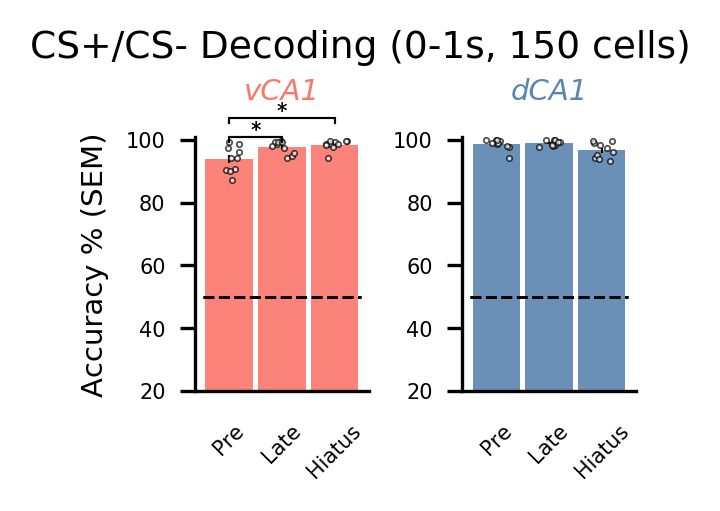

In [284]:
fig, ax = pl.subplots(1,2, figsize=(2, 1.5))
loops=10
tb='1s'
t=5 #time bin to plot (5 = 0-1s post odor delivery)
sess='post'
width=.9
for reg,r,co in zip(['vhpc','dhpc'],range(2),['#FC766AFF','#5B84B1FF']):
    for i,sess,la in zip(range(3),['expo','post','post_hiatus'],['Pre','Post','Hiatus']):
        #for i,t,c,la in zip(range(2),[5,8],['k','k'],['CS','Trace']):
            ax[r].bar(i,np.mean(eval("scores_cspm_%s_%s_ncells_%s[sess][140:150]"%(tb,t,reg)))*100,width=.9,
                      color=co,alpha=.9,label=la)
            exec("s_%s_%s_%s = np.array(np.std(scores_cspm_%s_%s_ncells_%s[sess][140:150])*100/np.sqrt(loops-1))"%(t,reg,sess,tb,t,reg))
            ax[r].errorbar(i,np.mean(eval("scores_cspm_%s_%s_ncells_%s[sess][140:150]"%(tb,t,reg)))*100,yerr=eval('s_%s_%s_%s'%(t,reg,sess)),color='k')
            ax[r].scatter(i+np.random.random(loops)*width/2-width/4.5,np.array(eval("scores_cspm_%s_%s_ncells_%s[sess][140:150]"%(tb,t,reg)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
            
for x in range (2):
    for y in range(2):
        ax[x].set_ylim(20, 101)
        #ax[x].set_xlim(-5, 9)
        ax[x].hlines(50, -0.5,2.5, color='k', lw=.7, linestyles='dashed')
        #ax[x].set_xlabel('Comparison')
        ax[0].set_ylabel('Accuracy % (SEM)')
        ax[x].set_xticks([0,1,2])
        ax[x].set_xticklabels(['Pre','Late','Hiatus'],fontsize=5,rotation=45)
        ax[x].tick_params(axis='x',bottom='off')

pvs=[]
sess=['expo','post','post_hiatus']
for reg,r in zip(['vhpc','dhpc'],range(2)):
    for q in [101,101]:
        pvs.append(add_significance(ax[r], eval("scores_cspm_%s_%s_ncells_%s[sess[0]][140:150]"%(tb,t,reg)),
                    eval("scores_cspm_%s_%s_ncells_%s[sess[1]][140:150]"%(tb,t,reg)),0,1,q,mcc=2))
        pvs.append(add_significance(ax[r], eval("scores_cspm_%s_%s_ncells_%s[sess[1]][140:150]"%(tb,t,reg)),
                    eval("scores_cspm_%s_%s_ncells_%s[sess[2]][140:150]"%(tb,t,reg)),1,2,q,mcc=2))
        pvs.append(add_significance(ax[r], eval("scores_cspm_%s_%s_ncells_%s[sess[0]][140:150]"%(tb,t,reg)),
                    eval("scores_cspm_%s_%s_ncells_%s[sess[2]][140:150]"%(tb,t,reg)),0,2,107,mcc=2))
    report_stats(eval("scores_cspm_%s_%s_ncells_%s[sess[0]][140:150]"%(tb,t,reg)),
                    eval("scores_cspm_%s_%s_ncells_%s[sess[1]][140:150]"%(tb,t,reg)),mcc=2)
    report_stats(eval("scores_cspm_%s_%s_ncells_%s[sess[1]][140:150]"%(tb,t,reg)),
                    eval("scores_cspm_%s_%s_ncells_%s[sess[2]][140:150]"%(tb,t,reg)),mcc=2)
    report_stats(eval("scores_cspm_%s_%s_ncells_%s[sess[0]][140:150]"%(tb,t,reg)),
                    eval("scores_cspm_%s_%s_ncells_%s[sess[2]][140:150]"%(tb,t,reg)),mcc=2)
#for i,t,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),sessions[1:]):
#        pvs.append(sig_vs_chance(ax[r],eval("scores_cspm_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k))[-loops:],.5,i,
#               np.mean(eval("scores_cspm_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('vCA1', y=1.05,color='#FC766AFF',fontstyle='italic')
ax[1].set_title('dCA1', y=1.05,color='#5B84B1FF',fontstyle='italic')
#ax[1].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("CS+/CS- Decoding (0-1s, 150 cells)", fontsize=9, y=1.05)

fig.tight_layout(pad=1)

fig.savefig('../figures/%s_CSpm_odor_ExPoHi_150cells.pdf'%NOTEBOOK_NAME)

U = 1.0 p = 0.000489609649049 r = -0.828251169634
U = 59.5 p = 0.990634907033 r = 0.160579308398
U = 1.0 p = 0.000484347571477 r = -0.828251169634
U = 0.0 p = 0.000363302292183 r = -0.845154254729
U = 82.0 p = 0.0345149121662 r = 0.540898723026
U = 2.0 p = 0.00065626662964 r = -0.811348084539


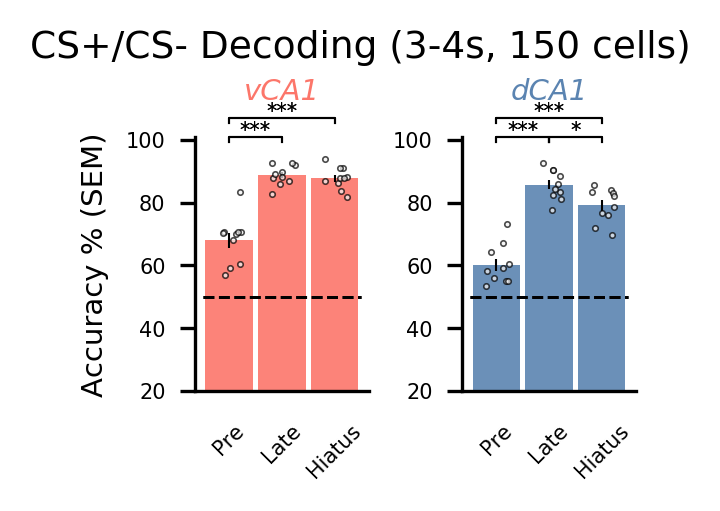

In [285]:
fig, ax = pl.subplots(1,2, figsize=(2, 1.5))
loops=10
tb='1s'
t=8 #time bin to plot (5 = 0-1s post odor delivery)
sess='post'
width=.9
for reg,r,co in zip(['vhpc','dhpc'],range(2),['#FC766AFF','#5B84B1FF']):
    for i,sess,la in zip(range(3),['expo','post','post_hiatus'],['Pre','Post','Hiatus']):
        #for i,t,c,la in zip(range(2),[5,8],['k','k'],['CS','Trace']):
            ax[r].bar(i,np.mean(eval("scores_cspm_%s_%s_ncells_%s[sess][150:160]"%(tb,t,reg)))*100,width=.9,
                      color=co,alpha=.9,label=la)
            exec("s_%s_%s_%s = np.array(np.std(scores_cspm_%s_%s_ncells_%s[sess][150:160])*100/np.sqrt(loops-1))"%(t,reg,sess,tb,t,reg))
            ax[r].errorbar(i,np.mean(eval("scores_cspm_%s_%s_ncells_%s[sess][150:160]"%(tb,t,reg)))*100,yerr=eval('s_%s_%s_%s'%(t,reg,sess)),color='k')
            ax[r].scatter(i+np.random.random(loops)*width/2-width/4.5,np.array(eval("scores_cspm_%s_%s_ncells_%s[sess][150:160]"%(tb,t,reg)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
            
for x in range (2):
    for y in range(2):
        ax[x].set_ylim(20, 101)
        #ax[x].set_xlim(-5, 9)
        ax[x].hlines(50, -0.5,2.5, color='k', lw=.7, linestyles='dashed')
        #ax[x].set_xlabel('Comparison')
        ax[0].set_ylabel('Accuracy % (SEM)')
        ax[x].set_xticks([0,1,2])
        ax[x].set_xticklabels(['Pre','Late','Hiatus'],fontsize=5,rotation=45)
        ax[x].tick_params(axis='x',bottom='off')

pvs=[]
sess=['expo','post','post_hiatus']
for reg,r in zip(['vhpc','dhpc'],range(2)):
    for q in [101,101]:
        pvs.append(add_significance(ax[r], eval("scores_cspm_%s_%s_ncells_%s[sess[0]][150:160]"%(tb,t,reg)),
                    eval("scores_cspm_%s_%s_ncells_%s[sess[1]][150:160]"%(tb,t,reg)),0,1,q,mcc=2))
        pvs.append(add_significance(ax[r], eval("scores_cspm_%s_%s_ncells_%s[sess[1]][150:160]"%(tb,t,reg)),
                    eval("scores_cspm_%s_%s_ncells_%s[sess[2]][150:160]"%(tb,t,reg)),1,2,q,mcc=2))
        pvs.append(add_significance(ax[r], eval("scores_cspm_%s_%s_ncells_%s[sess[0]][150:160]"%(tb,t,reg)),
                    eval("scores_cspm_%s_%s_ncells_%s[sess[2]][150:160]"%(tb,t,reg)),0,2,107,mcc=2))
    report_stats(eval("scores_cspm_%s_%s_ncells_%s[sess[0]][150:160]"%(tb,t,reg)),
                    eval("scores_cspm_%s_%s_ncells_%s[sess[1]][150:160]"%(tb,t,reg)),mcc=2)
    report_stats(eval("scores_cspm_%s_%s_ncells_%s[sess[1]][150:160]"%(tb,t,reg)),
                    eval("scores_cspm_%s_%s_ncells_%s[sess[2]][150:160]"%(tb,t,reg)),mcc=2)
    report_stats(eval("scores_cspm_%s_%s_ncells_%s[sess[0]][150:160]"%(tb,t,reg)),
                    eval("scores_cspm_%s_%s_ncells_%s[sess[2]][150:160]"%(tb,t,reg)),mcc=2)

ax[0].set_title('vCA1', y=1.05,color='#FC766AFF',fontstyle='italic')
ax[1].set_title('dCA1', y=1.05,color='#5B84B1FF',fontstyle='italic')
pl.suptitle("CS+/CS- Decoding (3-4s, 150 cells)", fontsize=9, y=1.05)

fig.tight_layout(pad=1)

fig.savefig('../figures/%s_CSpm_trace_ExPoHi_150cells.pdf'%NOTEBOOK_NAME)

# left off here

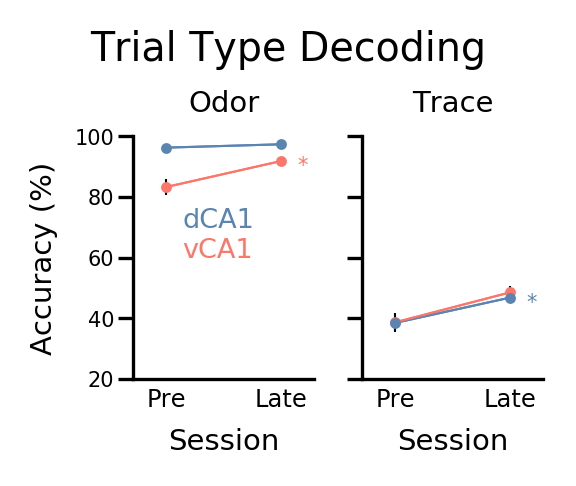

In [402]:
fig,ax = pl.subplots(1,2,figsize=(2,1.5),sharey=True)
v={}
d={}
loops=10
expectations = 'expo','post'
tb='1s'
# Add connecting lines            
for ex,z in zip(expectations,(.4,1.1)):
    for t,tb_la,x in zip((5,8),('Odor','Trace'),(range(2))):
        ax[x].plot([p for p in (.4,1.1)],[np.mean(eval("scores_%s_%s_ncells_dhpc[ex][150:160]"%(tb,t)))*100 for ex in expectations],
                   color='#5B84B1FF')
        ax[x].plot([p for p in (.4,1.1)],[np.mean(eval("scores_%s_%s_ncells_vhpc[ex][150:160]"%(tb,t)))*100 for ex in expectations],
                   color='#FC766AFF')
            
for ex,z in zip(['expo','post'],(.4,1.1)):
    for t,tb_la,x in zip((5,8),('Odor','Trace'),(range(2))):
        #for comp,c in zip (['rw','sh','csm'],['m','sandybrown','c']):
            v[ex] = np.std(eval("scores_%s_%s_ncells_vhpc[ex][150:160]"%(tb,t)))*100/np.sqrt(loops)
            d[ex] = np.std(eval("scores_%s_%s_ncells_dhpc[ex][150:160]"%(tb,t)))*100/np.sqrt(loops)
            ax[x].plot(z, np.mean(eval("scores_%s_%s_ncells_vhpc[ex][150:160]"%(tb,t)))*100, 'o',
                       color='#FC766AFF',mec='#FC766AFF',markersize=2,mew=0.6)
            ax[x].plot(z, np.mean(eval("scores_%s_%s_ncells_dhpc[ex][150:160]"%(tb,t)))*100, 'o',
                       color='#5B84B1FF',mec='#5B84B1FF',markersize=2,mew=0.6)            
            ax[x].errorbar(z, np.mean(eval("scores_%s_%s_ncells_vhpc[ex][150:160]"%(tb,t)))*100,yerr=v[ex],color='k')  
            ax[x].errorbar(z, np.mean(eval("scores_%s_%s_ncells_dhpc[ex][150:160]"%(tb,t)))*100,yerr=d[ex],color='k')  
        
            ax[x].tick_params(axis='x',bottom=False,pad=-1.5) # labels along the bottom edge are off
            ax[x].tick_params(axis='y',pad=1) # labels along the bottom edge are off
            ax[0].set_ylabel('Accuracy (%)')
            ax[x].set_ylim(20,100)
            #ax[x].hlines(33, 0.2,1.3, color='k', lw=.6, linestyles='dashed')
            ax[x].set_title(tb_la,y=1)
            ax[x].set_xlim(0.2,1.3)
            ax[x].set_xticks((.4,1.1))
            ax[x].set_xticklabels(['Pre','Late'],fontsize=5.8)
            ax[x].set_xlabel("Session")
            
from matplotlib.lines import Line2D

pvs=[]
for x,t in zip([0,1],[5,8]):
        pvs.append(add_significance_point(ax[x],eval("scores_%s_%s_ncells_vhpc['expo'][150:160]"%(tb,t)),
           eval("scores_%s_%s_ncells_vhpc['post'][150:160]"%(tb,t)),
           1.23,np.mean(eval("scores_%s_%s_ncells_vhpc['post'][150:160]"%(tb,t)))*100-3.5,color='#FC766AFF'))
        pvs.append(add_significance_point(ax[x],eval("scores_%s_%s_ncells_dhpc['expo'][150:160]"%(tb,t)),
           eval("scores_%s_%s_ncells_dhpc['post'][150:160]"%(tb,t)),
           1.23,np.mean(eval("scores_%s_%s_ncells_dhpc['post'][150:160]"%(tb,t)))*100-3.5,color='#5B84B1FF'))
        
ax[0].text(.5,60,'vCA1',color='#FC766AFF',fontsize=6.5)
ax[0].text(.5,70,'dCA1',color='#5B84B1FF',fontsize=6.5)

fig.suptitle('Trial Type Decoding',fontsize=9.5,y=1.04)
fig.tight_layout(pad=2)

fig.savefig('../figures/%s_lines_ExPo.pdf'%NOTEBOOK_NAME)

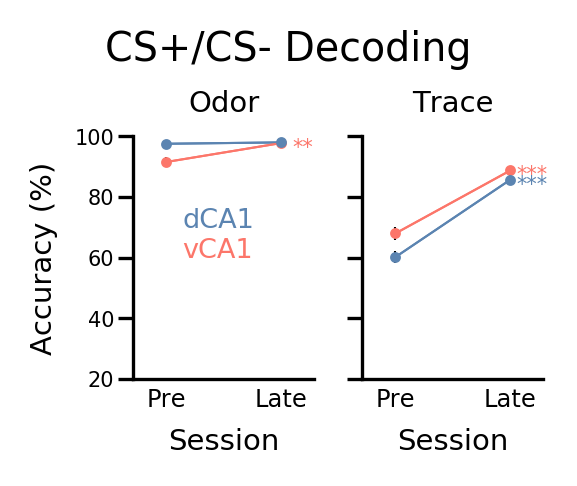

In [17]:
fig,ax = pl.subplots(1,2,figsize=(2,1.5),sharey=True)
v={}
d={}
loops=10
expectations = 'expo','post'
tb='1s'
# Add connecting lines            
for ex,z in zip(expectations,(.4,1.1)):
    for t,tb_la,x in zip((5,8),('Odor','Trace'),(range(2))):
        ax[x].plot([p for p in (.4,1.1)],[np.mean(eval("scores_cspm_%s_%s_ncells_dhpc[ex][150:160]"%(tb,t)))*100 for ex in expectations],
                   color='#5B84B1FF')
        ax[x].plot([p for p in (.4,1.1)],[np.mean(eval("scores_cspm_%s_%s_ncells_vhpc[ex][150:160]"%(tb,t)))*100 for ex in expectations],
                   color='#FC766AFF')
            
for ex,z in zip(['expo','post'],(.4,1.1)):
    for t,tb_la,x in zip((5,8),('Odor','Trace'),(range(2))):
        #for comp,c in zip (['rw','sh','csm'],['m','sandybrown','c']):
            v[ex] = np.std(eval("scores_cspm_%s_%s_ncells_vhpc[ex][150:160]"%(tb,t)))*100/np.sqrt(loops)
            d[ex] = np.std(eval("scores_cspm_%s_%s_ncells_dhpc[ex][150:160]"%(tb,t)))*100/np.sqrt(loops)
            ax[x].plot(z, np.mean(eval("scores_cspm_%s_%s_ncells_vhpc[ex][150:160]"%(tb,t)))*100, 'o',
                       color='#FC766AFF',mec='#FC766AFF',markersize=2,mew=0.6)
            ax[x].plot(z, np.mean(eval("scores_cspm_%s_%s_ncells_dhpc[ex][150:160]"%(tb,t)))*100, 'o',
                       color='#5B84B1FF',mec='#5B84B1FF',markersize=2,mew=0.6)            
            ax[x].errorbar(z, np.mean(eval("scores_cspm_%s_%s_ncells_vhpc[ex][150:160]"%(tb,t)))*100,yerr=v[ex],color='k')  
            ax[x].errorbar(z, np.mean(eval("scores_cspm_%s_%s_ncells_dhpc[ex][150:160]"%(tb,t)))*100,yerr=d[ex],color='k')  
        
            ax[x].tick_params(axis='x',bottom=False,pad=-1.5) # labels along the bottom edge are off
            ax[x].tick_params(axis='y',pad=1) # labels along the bottom edge are off
            ax[0].set_ylabel('Accuracy (%)')
            ax[x].set_ylim(20,100)
            #ax[x].hlines(33, 0.2,1.3, color='k', lw=.6, linestyles='dashed')
            ax[x].set_title(tb_la,y=1)
            ax[x].set_xlim(0.2,1.3)
            ax[x].set_xticks((.4,1.1))
            ax[x].set_xticklabels(['Pre','Late'],fontsize=5.8)
            ax[x].set_xlabel("Session")
            
from matplotlib.lines import Line2D

pvs=[]
for x,t in zip([0,1],[5,8]):
        pvs.append(add_significance_point(ax[x],eval("scores_cspm_%s_%s_ncells_vhpc['expo'][150:160]"%(tb,t)),
           eval("scores_cspm_%s_%s_ncells_vhpc['post'][150:160]"%(tb,t)),
           1.23,np.mean(eval("scores_cspm_%s_%s_ncells_vhpc['post'][150:160]"%(tb,t)))*100-3.5,color='#FC766AFF'))
        pvs.append(add_significance_point(ax[x],eval("scores_cspm_%s_%s_ncells_dhpc['expo'][150:160]"%(tb,t)),
           eval("scores_cspm_%s_%s_ncells_dhpc['post'][150:160]"%(tb,t)),
           1.23,np.mean(eval("scores_cspm_%s_%s_ncells_dhpc['post'][150:160]"%(tb,t)))*100-3.5,color='#5B84B1FF'))
        
ax[0].text(.5,60,'vCA1',color='#FC766AFF',fontsize=6.5)
ax[0].text(.5,70,'dCA1',color='#5B84B1FF',fontsize=6.5)

fig.suptitle('CS+/CS- Decoding',fontsize=9.5,y=1.04)
fig.tight_layout(pad=2)

fig.savefig('../figures/%s_lines_CSpm_ExPo.pdf'%NOTEBOOK_NAME)

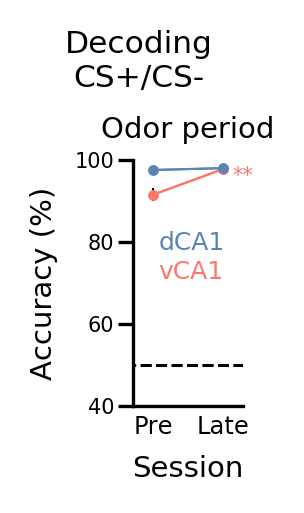

In [401]:
fig,ax = pl.subplots(1,1,figsize=(1,1.5),sharey=True)
v={}
d={}
loops=10
expectations = 'expo','post'
tb='1s'
t=5
tb_la='Odor'
# Add connecting lines            
for ex,z in zip(expectations,(.4,1.1)):
        ax.plot([p for p in (.4,1.1)],[np.mean(eval("scores_cspm_%s_%s_ncells_dhpc[ex][150:160]"%(tb,t)))*100 for ex in expectations],
                   color='#5B84B1FF')
        ax.plot([p for p in (.4,1.1)],[np.mean(eval("scores_cspm_%s_%s_ncells_vhpc[ex][150:160]"%(tb,t)))*100 for ex in expectations],
                   color='#FC766AFF')
for ex,z in zip(expectations,(.4,1.1)):            
        v[ex] = np.std(eval("scores_cspm_%s_%s_ncells_vhpc[ex][150:160]"%(tb,t)))*100/np.sqrt(loops)
        d[ex] = np.std(eval("scores_cspm_%s_%s_ncells_dhpc[ex][150:160]"%(tb,t)))*100/np.sqrt(loops)
        ax.plot(z, np.mean(eval("scores_cspm_%s_%s_ncells_vhpc[ex][150:160]"%(tb,t)))*100, 'o',
                   color='#FC766AFF',mec='#FC766AFF',markersize=2,mew=0.6)
        ax.plot(z, np.mean(eval("scores_cspm_%s_%s_ncells_dhpc[ex][150:160]"%(tb,t)))*100, 'o',
                   color='#5B84B1FF',mec='#5B84B1FF',markersize=2,mew=0.6)            
        ax.errorbar(z, np.mean(eval("scores_cspm_%s_%s_ncells_vhpc[ex][150:160]"%(tb,t)))*100,yerr=v[ex],color='k')  
        ax.errorbar(z, np.mean(eval("scores_cspm_%s_%s_ncells_dhpc[ex][150:160]"%(tb,t)))*100,yerr=d[ex],color='k')  
        ax.hlines(50, -0.5,1.5, color='k', lw=.7, linestyles='dashed')
        ax.tick_params(axis='x',bottom=False,pad=-1.5) # labels along the bottom edge are off
        ax.tick_params(axis='y',pad=1) # labels along the bottom edge are off
        ax.set_ylabel('Accuracy (%)')
        ax.set_ylim(40,100)
        ax.set_title(tb_la+" period",y=.99)
        ax.set_xlim(0.2,1.3)
        ax.set_xticks((.4,1.1))
        ax.set_xticklabels(['Pre','Late'],fontsize=5.8)
        ax.set_xlabel("Session")
            
from matplotlib.lines import Line2D

pvs=[]
pvs.append(add_significance_point(ax,eval("scores_cspm_%s_%s_ncells_vhpc['expo'][150:160]"%(tb,t)),
   eval("scores_cspm_%s_%s_ncells_vhpc['post'][150:160]"%(tb,t)),
   1.3,np.mean(eval("scores_cspm_%s_%s_ncells_vhpc['post'][150:160]"%(tb,t)))*100-3,color='#FC766AFF'))
pvs.append(add_significance_point(ax,eval("scores_cspm_%s_%s_ncells_dhpc['expo'][150:160]"%(tb,t)),
   eval("scores_cspm_%s_%s_ncells_dhpc['post'][150:160]"%(tb,t)),
   1.3,np.mean(eval("scores_cspm_%s_%s_ncells_dhpc['post'][150:160]"%(tb,t)))*100-3,color='#5B84B1FF'))

ax.text(.45,71,'vCA1',color='#FC766AFF',fontsize=6)
ax.text(.45,78,'dCA1',color='#5B84B1FF',fontsize=6)

fig.suptitle('Decoding\nCS+/CS-',fontsize=7.5,y=1.1)
fig.tight_layout(pad=2)

fig.savefig('../figures/%s_lines_CSpm_odor_ExPo.pdf'%NOTEBOOK_NAME)

vCA1 U = 1.0 p = 0.000244804824524 r = -0.828251169634
None
U = 0.0 p = 0.000181651146091 r = -0.845154254729


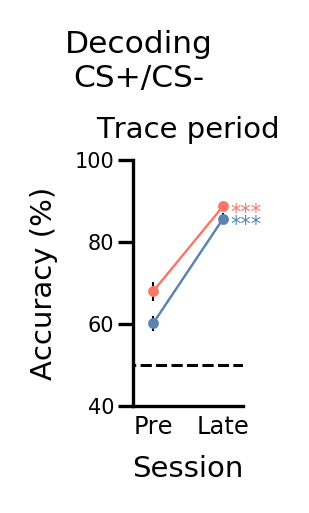

In [22]:
fig,ax = pl.subplots(1,1,figsize=(1,1.5),sharey=True)
v={}
d={}
loops=10
expectations = 'expo','post'
tb='1s'
t=8
tb_la='Trace'
# Add connecting lines            
for ex,z in zip(expectations,(.4,1.1)):
        ax.plot([p for p in (.4,1.1)],[np.mean(eval("scores_cspm_%s_%s_ncells_dhpc[ex][150:160]"%(tb,t)))*100 for ex in expectations],
                   color='#5B84B1FF')
        ax.plot([p for p in (.4,1.1)],[np.mean(eval("scores_cspm_%s_%s_ncells_vhpc[ex][150:160]"%(tb,t)))*100 for ex in expectations],
                   color='#FC766AFF')
for ex,z in zip(expectations,(.4,1.1)):            
        v[ex] = np.std(eval("scores_cspm_%s_%s_ncells_vhpc[ex][150:160]"%(tb,t)))*100/np.sqrt(loops)
        d[ex] = np.std(eval("scores_cspm_%s_%s_ncells_dhpc[ex][150:160]"%(tb,t)))*100/np.sqrt(loops)
        ax.plot(z, np.mean(eval("scores_cspm_%s_%s_ncells_vhpc[ex][150:160]"%(tb,t)))*100, 'o',
                   color='#FC766AFF',mec='#FC766AFF',markersize=2,mew=0.6)
        ax.plot(z, np.mean(eval("scores_cspm_%s_%s_ncells_dhpc[ex][150:160]"%(tb,t)))*100, 'o',
                   color='#5B84B1FF',mec='#5B84B1FF',markersize=2,mew=0.6)            
        ax.errorbar(z, np.mean(eval("scores_cspm_%s_%s_ncells_vhpc[ex][150:160]"%(tb,t)))*100,yerr=v[ex],color='k')  
        ax.errorbar(z, np.mean(eval("scores_cspm_%s_%s_ncells_dhpc[ex][150:160]"%(tb,t)))*100,yerr=d[ex],color='k')  
        ax.hlines(50, -0.5,1.5, color='k', lw=.7, linestyles='dashed')
        ax.tick_params(axis='x',bottom=False,pad=-1.5) # labels along the bottom edge are off
        ax.tick_params(axis='y',pad=1) # labels along the bottom edge are off
        ax.set_ylabel('Accuracy (%)')
        ax.set_ylim(40,100)
        ax.set_title(tb_la+" period",y=.99)
        ax.set_xlim(0.2,1.3)
        ax.set_xticks((.4,1.1))
        ax.set_xticklabels(['Pre','Late'],fontsize=5.8)
        ax.set_xlabel("Session")
            
from matplotlib.lines import Line2D

pvs=[]
pvs.append(add_significance_point(ax,eval("scores_cspm_%s_%s_ncells_vhpc['expo'][150:160]"%(tb,t)),
   eval("scores_cspm_%s_%s_ncells_vhpc['post'][150:160]"%(tb,t)),
   1.33,np.mean(eval("scores_cspm_%s_%s_ncells_vhpc['post'][150:160]"%(tb,t)))*100-3,color='#FC766AFF'))
pvs.append(add_significance_point(ax,eval("scores_cspm_%s_%s_ncells_dhpc['expo'][150:160]"%(tb,t)),
   eval("scores_cspm_%s_%s_ncells_dhpc['post'][150:160]"%(tb,t)),
   1.33,np.mean(eval("scores_cspm_%s_%s_ncells_dhpc['post'][150:160]"%(tb,t)))*100-3,color='#5B84B1FF'))
print 'vCA1',report_stats(eval("scores_cspm_%s_%s_ncells_vhpc['expo'][150:160]"%(tb,t)),
   eval("scores_cspm_%s_%s_ncells_vhpc['post'][150:160]"%(tb,t)))
report_stats(eval("scores_cspm_%s_%s_ncells_dhpc['expo'][150:160]"%(tb,t)),
   eval("scores_cspm_%s_%s_ncells_dhpc['post'][150:160]"%(tb,t)))

#ax.text(.5,60,'vCA1',color='#FC766AFF',fontsize=6.5)
#ax.text(.5,70,'dCA1',color='#5B84B1FF',fontsize=6.5)

fig.suptitle('Decoding\nCS+/CS-',fontsize=7.5,y=1.1)
fig.tight_layout(pad=2)

fig.savefig('../figures/%s_lines_CSpm_trace_ExPo.pdf'%NOTEBOOK_NAME)

vCA1 U = 19.5 p = 0.0232902349289 r = -0.515544095384
None
U = 37.5 p = 0.363261554225 r = -0.211288563682


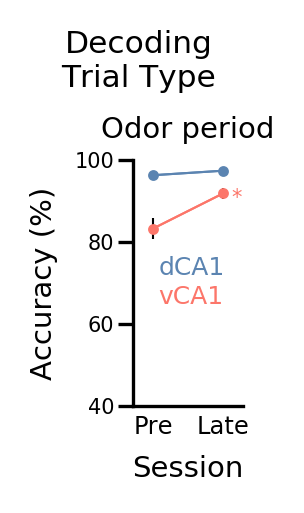

In [21]:
fig,ax = pl.subplots(1,1,figsize=(1,1.5),sharey=True)
v={}
d={}
loops=10
expectations = 'expo','post'
tb='1s'
t=5
tb_la='Odor'
# Add connecting lines            
for ex,z in zip(expectations,(.4,1.1)):
        ax.plot([p for p in (.4,1.1)],[np.mean(eval("scores_%s_%s_ncells_dhpc[ex][150:160]"%(tb,t)))*100 for ex in expectations],
                   color='#5B84B1FF')
        ax.plot([p for p in (.4,1.1)],[np.mean(eval("scores_%s_%s_ncells_vhpc[ex][150:160]"%(tb,t)))*100 for ex in expectations],
                   color='#FC766AFF')
for ex,z in zip(expectations,(.4,1.1)):            
        v[ex] = np.std(eval("scores_%s_%s_ncells_vhpc[ex][150:160]"%(tb,t)))*100/np.sqrt(loops)
        d[ex] = np.std(eval("scores_%s_%s_ncells_dhpc[ex][150:160]"%(tb,t)))*100/np.sqrt(loops)
        ax.plot(z, np.mean(eval("scores_%s_%s_ncells_vhpc[ex][150:160]"%(tb,t)))*100, 'o',
                   color='#FC766AFF',mec='#FC766AFF',markersize=2,mew=0.6)
        ax.plot(z, np.mean(eval("scores_%s_%s_ncells_dhpc[ex][150:160]"%(tb,t)))*100, 'o',
                   color='#5B84B1FF',mec='#5B84B1FF',markersize=2,mew=0.6)            
        ax.errorbar(z, np.mean(eval("scores_%s_%s_ncells_vhpc[ex][150:160]"%(tb,t)))*100,yerr=v[ex],color='k')  
        ax.errorbar(z, np.mean(eval("scores_%s_%s_ncells_dhpc[ex][150:160]"%(tb,t)))*100,yerr=d[ex],color='k')  
        ax.hlines(25, -0.5,1.5, color='k', lw=.7, linestyles='dashed')
        ax.tick_params(axis='x',bottom=False,pad=-1.5) # labels along the bottom edge are off
        ax.tick_params(axis='y',pad=1) # labels along the bottom edge are off
        ax.set_ylabel('Accuracy (%)')
        ax.set_ylim(40,100)
        ax.set_title(tb_la+" period",y=.99)
        ax.set_xlim(0.2,1.3)
        ax.set_xticks((.4,1.1))
        ax.set_xticklabels(['Pre','Late'],fontsize=5.8)
        ax.set_xlabel("Session")
            
from matplotlib.lines import Line2D

pvs=[]
pvs.append(add_significance_point(ax,eval("scores_%s_%s_ncells_vhpc['expo'][150:160]"%(tb,t)),
   eval("scores_%s_%s_ncells_vhpc['post'][150:160]"%(tb,t)),
   1.23,np.mean(eval("scores_%s_%s_ncells_vhpc['post'][150:160]"%(tb,t)))*100-2.5,color='#FC766AFF'))
pvs.append(add_significance_point(ax,eval("scores_%s_%s_ncells_dhpc['expo'][150:160]"%(tb,t)),
   eval("scores_%s_%s_ncells_dhpc['post'][150:160]"%(tb,t)),
   1.23,np.mean(eval("scores_%s_%s_ncells_dhpc['post'][150:160]"%(tb,t)))*100-2.5,color='#5B84B1FF'))
print 'vCA1',report_stats(eval("scores_%s_%s_ncells_vhpc['expo'][150:160]"%(tb,t)),
   eval("scores_%s_%s_ncells_vhpc['post'][150:160]"%(tb,t)))
report_stats(eval("scores_%s_%s_ncells_dhpc['expo'][150:160]"%(tb,t)),
   eval("scores_%s_%s_ncells_dhpc['post'][150:160]"%(tb,t)))

ax.text(.45,65,'vCA1',color='#FC766AFF',fontsize=6)
ax.text(.45,72,'dCA1',color='#5B84B1FF',fontsize=6)

fig.suptitle('Decoding\nTrial Type',fontsize=7.5,y=1.1)
fig.tight_layout(pad=2)

fig.savefig('../figures/%s_lines_odor_ExPo.pdf'%NOTEBOOK_NAME)

U = 19.5 p = 0.0231864266968 r = -0.515544095384
U = 16.0 p = 0.0112682466586 r = -0.574704893215


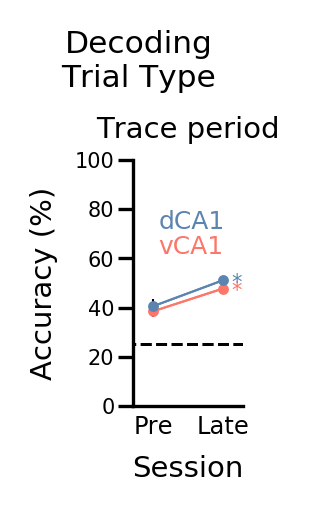

In [400]:
fig,ax = pl.subplots(1,1,figsize=(1,1.5),sharey=True)
v={}
d={}
loops=10
expectations = 'expo','post'
tb='1s'
t=8
tb_la='Trace'
# Add connecting lines            
for ex,z in zip(expectations,(.4,1.1)):
        ax.plot([p for p in (.4,1.1)],[np.mean(eval("scores_%s_%s_ncells_dhpc[ex][140:150]"%(tb,t)))*100 for ex in expectations],
                   color='#5B84B1FF')
        ax.plot([p for p in (.4,1.1)],[np.mean(eval("scores_%s_%s_ncells_vhpc[ex][140:150]"%(tb,t)))*100 for ex in expectations],
                   color='#FC766AFF')
for ex,z in zip(expectations,(.4,1.1)):            
        v[ex] = np.std(eval("scores_%s_%s_ncells_vhpc[ex][140:150]"%(tb,t)))*100/np.sqrt(loops)
        d[ex] = np.std(eval("scores_%s_%s_ncells_dhpc[ex][140:150]"%(tb,t)))*100/np.sqrt(loops)
        ax.plot(z, np.mean(eval("scores_%s_%s_ncells_vhpc[ex][140:150]"%(tb,t)))*100, 'o',
                   color='#FC766AFF',mec='#FC766AFF',markersize=2,mew=0.6)
        ax.plot(z, np.mean(eval("scores_%s_%s_ncells_dhpc[ex][140:150]"%(tb,t)))*100, 'o',
                   color='#5B84B1FF',mec='#5B84B1FF',markersize=2,mew=0.6)            
        ax.errorbar(z, np.mean(eval("scores_%s_%s_ncells_vhpc[ex][140:150]"%(tb,t)))*100,yerr=v[ex],color='k')  
        ax.errorbar(z, np.mean(eval("scores_%s_%s_ncells_dhpc[ex][140:150]"%(tb,t)))*100,yerr=d[ex],color='k')  
        ax.hlines(25, -0.5,1.5, color='k', lw=.7, linestyles='dashed')
        ax.tick_params(axis='x',bottom=False,pad=-1.5) # labels along the bottom edge are off
        ax.tick_params(axis='y',pad=1) # labels along the bottom edge are off
        ax.set_ylabel('Accuracy (%)')
        ax.set_ylim(0,100)
        ax.set_title(tb_la+" period",y=.99)
        ax.set_xlim(0.2,1.3)
        ax.set_xticks((.4,1.1))
        ax.set_xticklabels(['Pre','Late'],fontsize=5.8)
        ax.set_xlabel("Session")
            
from matplotlib.lines import Line2D

pvs=[]
pvs.append(add_significance_point(ax,eval("scores_%s_%s_ncells_vhpc['expo'][140:150]"%(tb,t)),
   eval("scores_%s_%s_ncells_vhpc['post'][140:150]"%(tb,t)),
   1.23,np.mean(eval("scores_%s_%s_ncells_vhpc['post'][140:150]"%(tb,t)))*100-3.5,color='#FC766AFF'))
pvs.append(add_significance_point(ax,eval("scores_%s_%s_ncells_dhpc['expo'][140:150]"%(tb,t)),
   eval("scores_%s_%s_ncells_dhpc['post'][140:150]"%(tb,t)),
   1.23,np.mean(eval("scores_%s_%s_ncells_dhpc['post'][140:150]"%(tb,t)))*100-3.5,color='#5B84B1FF'))
report_stats(eval("scores_%s_%s_ncells_vhpc['expo'][140:150]"%(tb,t)),
                    eval("scores_%s_%s_ncells_vhpc['post'][140:150]"%(tb,t)))
report_stats(eval("scores_%s_%s_ncells_dhpc['expo'][140:150]"%(tb,t)),
                    eval("scores_%s_%s_ncells_dhpc['post'][140:150]"%(tb,t)))

ax.text(.45,62,'vCA1',color='#FC766AFF',fontsize=6)
ax.text(.45,72,'dCA1',color='#5B84B1FF',fontsize=6)

fig.suptitle('Decoding\nTrial Type',fontsize=7.5,y=1.1)
fig.tight_layout(pad=2)

fig.savefig('../figures/%s_lines_trace_ExPo.pdf'%NOTEBOOK_NAME)

In [41]:
save_workspace(db)

Could not store variable 'IPython'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'np'. Skipping...
